<a href="https://colab.research.google.com/github/dspselorm/Recommendation-System-Analysis/blob/main/Recommendation_System_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RECOMMENDATION SYSTEM ANALYSIS AND MODELING PROJECT**

### **GOAL**

Personalize item suggestions for users based on their interaction history (clicks, add to cart, and transactions)

### **OBJECTIVES**

1.	Develop Personalized Recommendations

2.	Implement systems for product, content, and service recommendations.

3.	Leverage past user actions to make accurate predictions.

4.	Improve user satisfaction and retention through relevant suggestions.

5.	Ensure Scalability & Real-Time Performance

6.	Increase sales and conversion rates through better user personalization.

7.  Balance Accuracy & Diversity – Provide relevant but varied recommendations to avoid monotony

### **ANALYTICAL QUESTIONS**

Using the CRISP-DM Framework

1.	What common item properties are most frequently associated with items users add to cart after viewing?

2.	How does the time spent viewing an item influence the likelihood of it being added to the cart or purchased?

3.	Are there users whose behavior patterns (e.g., excessively high number of clicks, zero add-to-cart or purchase) deviate significantly from typical user behavior?

4.	Do abnormal users tend to interact with a specific subset of items or categories?

5.	What is the conversion funnel across the platform: from view → add to cart → transaction, and how does it vary across item categories or user types?

6.	When do users engage most with the platform, and does this affect conversions?

7.	What are the most effective features for distinguishing normal from abnormal users?

8.	Can user viewing patterns be used to accurately predict the category of the item they are likely to add to cart?


### **Libraries**

In [1]:
import pandas as pd
import numpy as np
import re
import glob
import os
import duckdb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, top_k_accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import joblib

from fastapi import FastAPI
from pydantic import BaseModel

### **Import Google Drive Content**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Merge the two "Item_Properties.csv" files**

In [ ]:
# Define the path to your data folder
data_folder = '/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/Item_properties_data'
items_properties_data = glob.glob(os.path.join(data_folder, "*.csv"))

# Read and combine all CSV files in 2020 folder
df_item = []

for file in items_properties_data:
    try:
        df = pd.read_csv(file)
        df_item.append(df)
        print(f"Loaded: {os.path.basename(file)} with {len(df)} rows")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Concatenate all DataFrames into one
combined_df = pd.concat(df_item, ignore_index=True)
print(f"Successfully merged {len(df_item)} files into a single DataFrame with {len(combined_df)} rows.")

# Save the combined data
output_path = os.path.join('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/', "item_properties_merged.csv")
combined_df.to_csv(output_path, index=False)
print(f"Merged file saved to: {output_path}")

Loaded: item_properties_part1.1.csv with 10999999 rows
Loaded: item_properties_part2.csv with 5638803 rows
Successfully merged 2 files into a single DataFrame with 16638802 rows.
Merged file saved to: /content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/item_properties_merged.csv


### **Upload Datasets**

**1. Item_Properties Dataset**

In [ ]:
chunksize = 100000
chunks = []

for chunk in pd.read_csv('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/item_properties_merged.csv', chunksize=chunksize):

    chunks.append(chunk)

df_item_properties = pd.concat(chunks, ignore_index=True)
print("File loaded successfully with shape:", df_item_properties.shape)

File loaded successfully with shape: (16638802, 4)


**2. Category_Tree Dataset**

In [ ]:
df_category_tree = pd.read_csv('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/category_tree.csv')
print("File loaded successfully with shape:", df_category_tree.shape)

File loaded successfully with shape: (1669, 2)


**3. Events Dataset**

In [ ]:
df_events = pd.read_csv('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/events.csv')
print("File loaded successfully with shape:", df_events.shape)

File loaded successfully with shape: (2756101, 5)


In [ ]:
df_item_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638802 entries, 0 to 16638801
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 507.8+ MB


In [ ]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [ ]:
df_category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


**Filter out rows where property is 'categoryid' or 'available'**

In [ ]:
# Filter out rows where property is 'categoryid' or 'available'
df_item_properties_filtered = df_item_properties[
    df_item_properties['property'].isin(['categoryid', 'available'])
]

# Save to CSV
df_item_properties_filtered.to_csv('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/item_properties_filtered.csv', index=False)

print(f"Filtered dataset saved with {len(df_item_properties_filtered)} rows.")

Filtered dataset saved with 1881100 rows.


In [ ]:
df_item_properties_filtered

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
5,1436065200000,285026,available,0
15,1437274800000,186518,available,0
79,1433646000000,423682,available,0
82,1434250800000,316253,available,1
...,...,...,...,...
16638759,1442113200000,409366,available,1
16638761,1431831600000,376865,available,1
16638763,1431831600000,286888,categoryid,1277
16638786,1438484400000,264025,available,1


## **Begin Data Preparation**

In [ ]:
df_category_tree['parentid'] = df_category_tree['parentid'].fillna(0).astype(int)
df_category_tree['parentid'] = df_category_tree['parentid'].fillna(0).astype(str)
df_category_tree['categoryid'] = df_category_tree['categoryid'].astype(str)

**Correct Date Columns**

In [ ]:
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'], unit='ms', errors='coerce')
df_item_properties_filtered['timestamp'] = pd.to_datetime(df_item_properties_filtered['timestamp'], unit='ms', errors='coerce')

/tmp/ipython-input-1873278124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_item_properties_filtered['timestamp'] = pd.to_datetime(df_item_properties_filtered['timestamp'], unit='ms', errors='coerce')


**Correct itemid column datatypes**

In [ ]:
df_events['itemid'] = pd.to_numeric(df_events['itemid'], errors='coerce')
df_item_properties['itemid'] = pd.to_numeric(df_item_properties['itemid'], errors='coerce')

**Correct Transaction ID Datatype**

In [ ]:
# Change Transaction ID to int, Null Values remain null
df_events['transactionid'] = df_events['transactionid'].apply(lambda x: '' if pd.isna(x) else str(int(x)))

In [ ]:
text_only_props = df_item_properties.loc[
    ~df_item_properties['property'].str.fullmatch(r'\d+(\.\d+)?')
]['property'].unique()
text_only_props

array(['categoryid', 'available'], dtype=object)

**Merge Event dataset with Filtered Item Properties Dataset**

In [ ]:
# Register in DuckDB
duckdb.register('events', df_events)
duckdb.register('item_props_filtered', df_item_properties_filtered)

# Merge & pivot categoryid and available
df_merged = duckdb.query("""
WITH props AS (
    SELECT
        itemid,
        timestamp,
        MAX(CASE WHEN property = 'categoryid' THEN value END) AS categoryid,
        MAX(CASE WHEN property = 'available' THEN value END) AS available
    FROM df_item_properties_filtered
    GROUP BY itemid, timestamp
),
latest_props AS (
    SELECT *
    FROM (
        SELECT
            e.*,
            p.categoryid,
            p.available,
            ROW_NUMBER() OVER (
                PARTITION BY e.itemid, e.timestamp
                ORDER BY p.timestamp DESC
            ) AS rn
        FROM events e
        LEFT JOIN props p
        ON e.itemid = p.itemid
        AND p.timestamp <= e.timestamp
    )
    WHERE rn = 1
)
SELECT * EXCLUDE (rn)
FROM latest_props
""").to_df()

# Save merged file
df_merged.to_csv("/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/Cleaned/merged_events_properties.csv", index=False)

print("Merge complete. Shape:", df_merged.shape)
df_merged

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Merge complete. Shape: (2755607, 7)


,timestamp,visitorid,event,itemid,transactionid,categoryid,available
0,2015-08-20 20:38:19.422,1238415,view,308519,,None,0
1,2015-06-17 03:51:36.952,177912,view,308538,,None,0
2,2015-06-28 19:07:58.978,264504,view,308538,,None,0
3,2015-07-19 03:01:56.026,371606,view,308538,,None,0
4,2015-07-31 00:09:33.274,787102,view,308538,,None,0
...,...,...,...,...,...,...,...
2755602,2015-06-02 16:22:13.920,773974,view,299375,,None,0
2755603,2015-08-14 17:19:54.082,963621,view,299375,,281,None
2755604,2015-06-17 00:48:23.775,359094,view,299384,,None,1
2755605,2015-08-17 22:57:40.806,1150086,view,299384,,None,1


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755607 entries, 0 to 2755606
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  object        
 5   categoryid     object        
 6   available      object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 147.2+ MB


In [ ]:
df_final = pd.merge(df_merged, df_category_tree, on='categoryid', how='left')

In [ ]:
df_final

,timestamp,visitorid,event,itemid,transactionid,categoryid,available,parentid
0,2015-08-20 20:38:19.422,1238415,view,308519,,None,0,NaN
1,2015-06-17 03:51:36.952,177912,view,308538,,None,0,NaN
2,2015-06-28 19:07:58.978,264504,view,308538,,None,0,NaN
3,2015-07-19 03:01:56.026,371606,view,308538,,None,0,NaN
4,2015-07-31 00:09:33.274,787102,view,308538,,None,0,NaN
...,...,...,...,...,...,...,...,...
2755602,2015-06-02 16:22:13.920,773974,view,299375,,None,0,NaN
2755603,2015-08-14 17:19:54.082,963621,view,299375,,281,None,1424
2755604,2015-06-17 00:48:23.775,359094,view,299384,,None,1,NaN
2755605,2015-08-17 22:57:40.806,1150086,view,299384,,None,1,NaN


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755607 entries, 0 to 2755606
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  object        
 5   categoryid     object        
 6   available      object        
 7   parentid       object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 168.2+ MB


In [ ]:
df_final.isnull().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,0
categoryid,1851592
available,1082839
parentid,1851592


In [ ]:
# Save merged file
df_final.to_csv("/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/Cleaned/full_cleaned_dataset_events_properties_category.csv", index=False)

## **Load Fully Cleaned Dataset to begin Visualizations and Analysis**

---



In [2]:
df_cleaned_final = pd.read_csv('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/Cleaned/full_cleaned_dataset_events_properties_category.csv')

In [3]:
df_cleaned_final['timestamp'] = pd.to_datetime(df_cleaned_final['timestamp'], errors='coerce')
df_cleaned_final['transactionid'] = df_cleaned_final['transactionid'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan).astype('object')
df_cleaned_final['categoryid'] = df_cleaned_final['categoryid'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan).astype('object')
df_cleaned_final['available'] = df_cleaned_final['available'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan).astype('object')
df_cleaned_final['parentid'] = df_cleaned_final['parentid'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan).astype('object')

In [4]:
df_cleaned_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755607 entries, 0 to 2755606
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  object        
 5   categoryid     object        
 6   available      object        
 7   parentid       object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 168.2+ MB


In [5]:
df_cleaned_final

,timestamp,visitorid,event,itemid,transactionid,categoryid,available,parentid
0,2015-08-20 20:38:19.422,1238415,view,308519,NaN,NaN,0,NaN
1,2015-06-17 03:51:36.952,177912,view,308538,NaN,NaN,0,NaN
2,2015-06-28 19:07:58.978,264504,view,308538,NaN,NaN,0,NaN
3,2015-07-19 03:01:56.026,371606,view,308538,NaN,NaN,0,NaN
4,2015-07-31 00:09:33.274,787102,view,308538,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...
2755602,2015-06-02 16:22:13.920,773974,view,299375,NaN,NaN,0,NaN
2755603,2015-08-14 17:19:54.082,963621,view,299375,NaN,281,NaN,1424
2755604,2015-06-17 00:48:23.775,359094,view,299384,NaN,NaN,1,NaN
2755605,2015-08-17 22:57:40.806,1150086,view,299384,NaN,NaN,1,NaN


In [6]:
df_cleaned_final.isnull().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733150
categoryid,1851592
available,1082839
parentid,1851592


## **VISUALIZATIONS AND ANALYSIS**

### **1. What common item properties are most frequently associated with items users add to cart after viewing?**

/tmp/ipython-input-1198963151.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


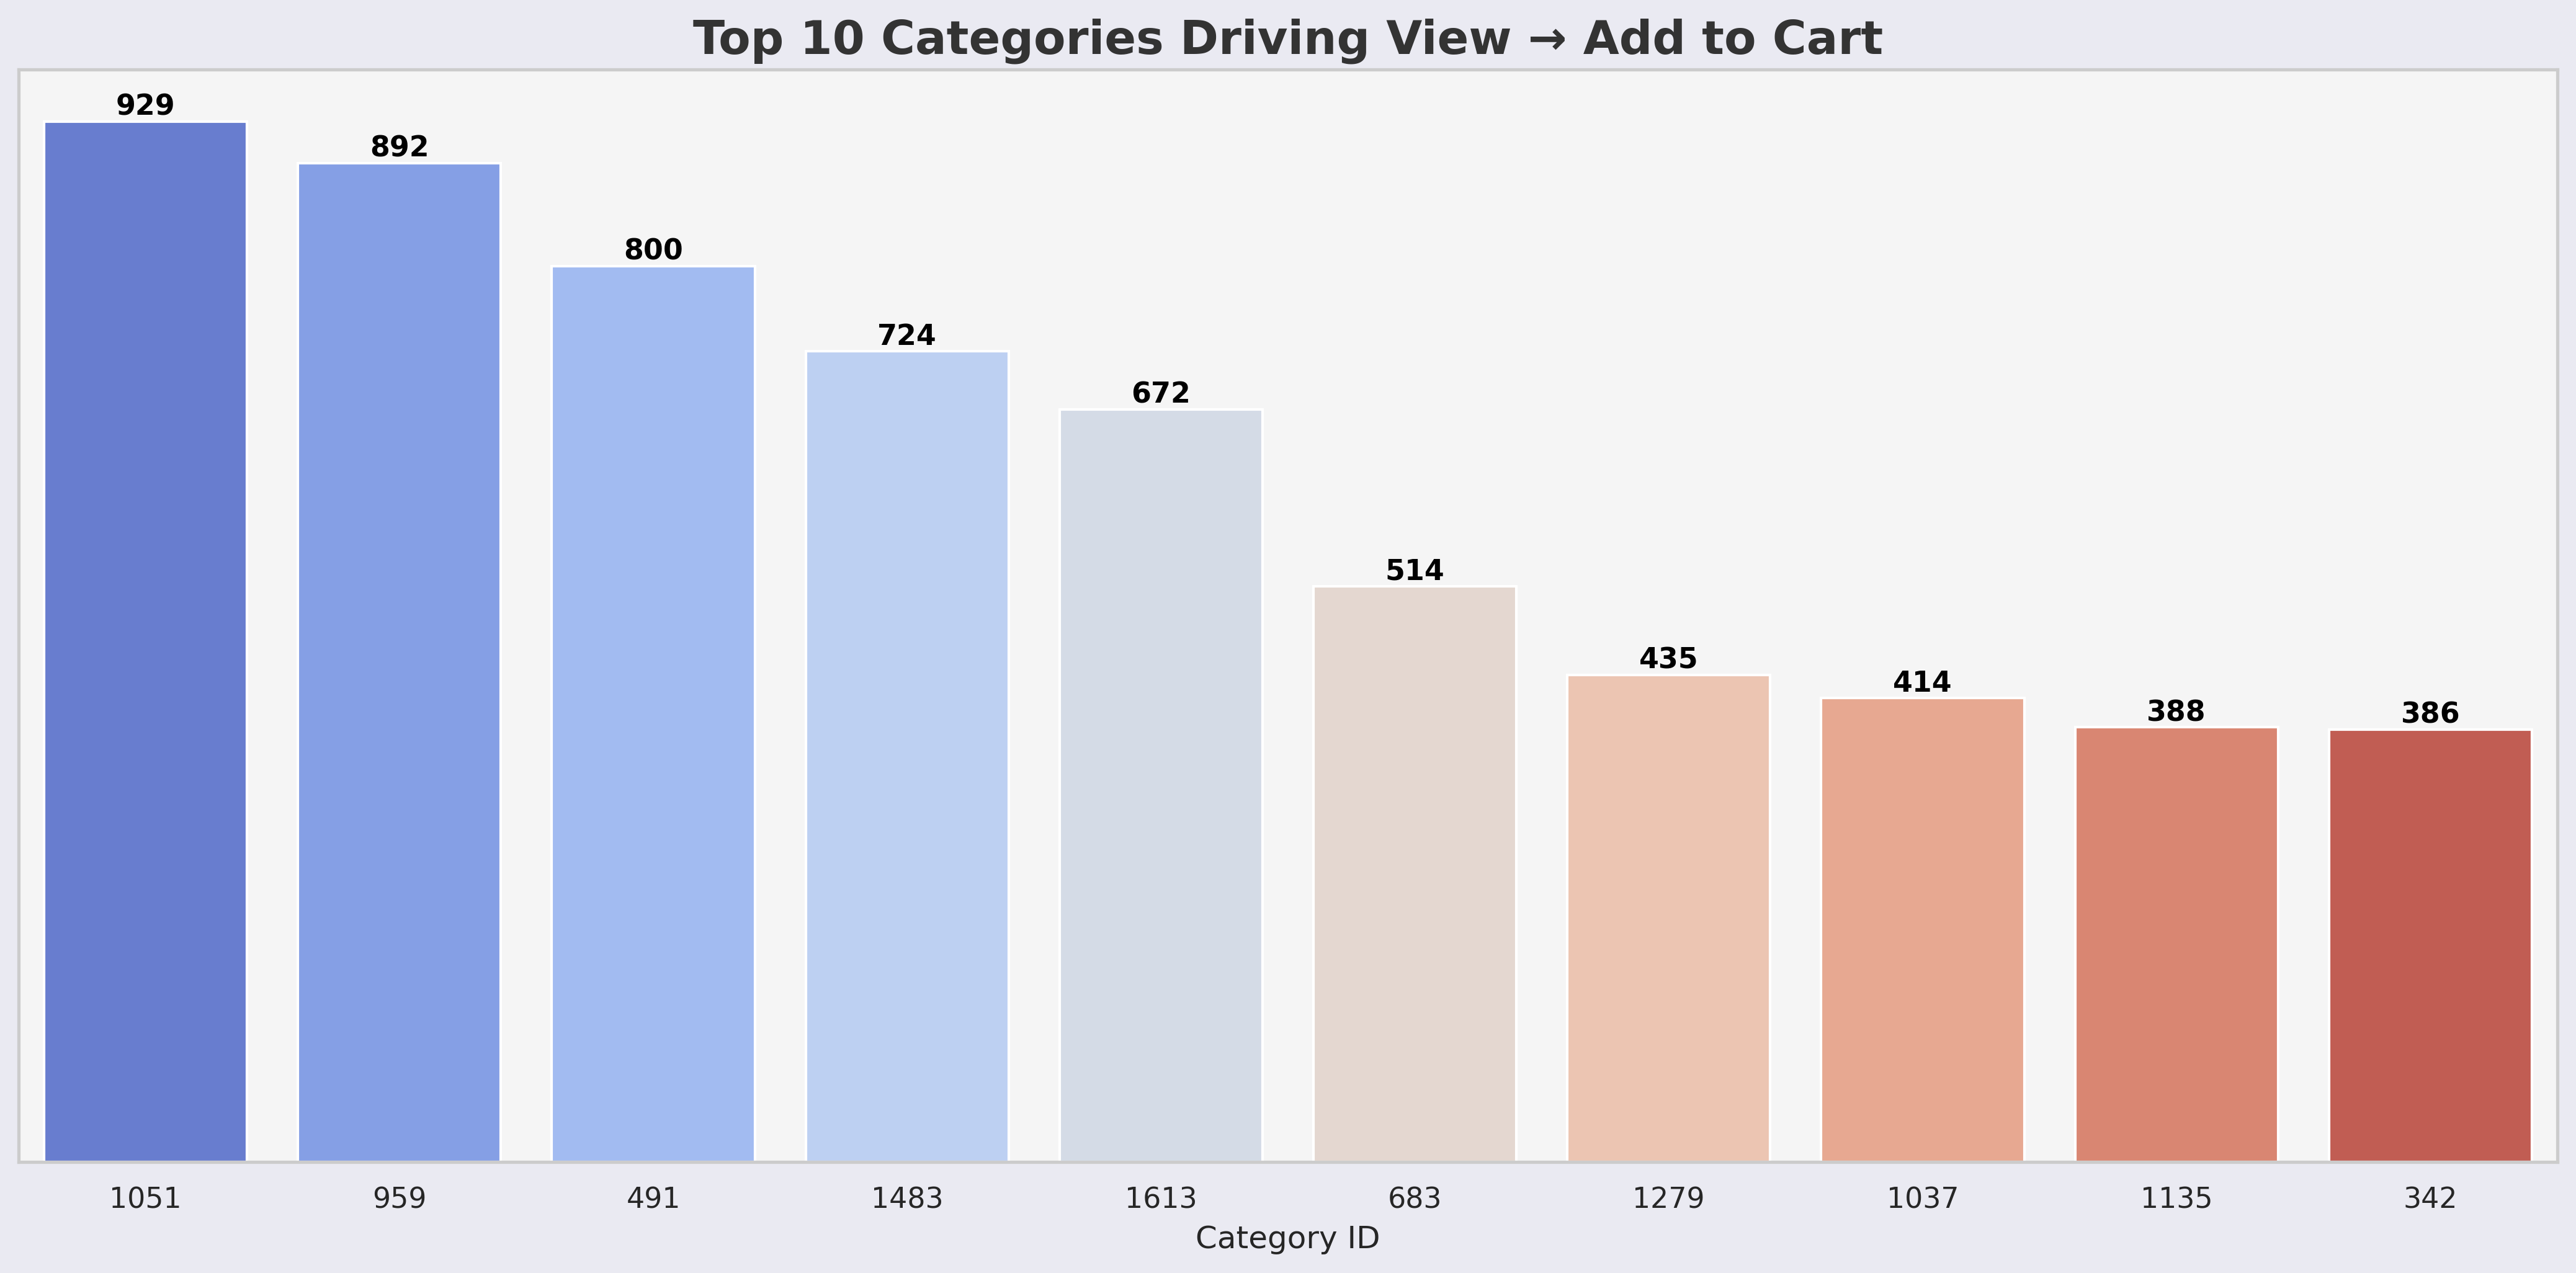

In [ ]:
# Filter for 'view' and 'addtocart'
df_view_cart = df_cleaned_final[df_cleaned_final['event'].isin(['view', 'addtocart'])]

# Identify items where the same user viewed and then added to cart
converted_items = (
    df_view_cart.groupby(['visitorid', 'itemid'])['event']
    .apply(lambda x: set(x) >= {'view', 'addtocart'})
    .reset_index()
)
converted_items = converted_items[converted_items['event'] == True][['visitorid', 'itemid']]

# Merge to get properties
converted_with_props = converted_items.merge(
    df_cleaned_final[['itemid', 'categoryid']],
    on='itemid',
    how='left'
).drop_duplicates()

# Count top categories
top_cats = converted_with_props['categoryid'].value_counts().head(10).reset_index()
top_cats.columns = ['categoryid', 'count']

# Sort for plotting
top_cats_sorted = top_cats.sort_values(by='count', ascending=False)

# Style and figure settings
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7), dpi=300)

# Bar plot
bar = sns.barplot(
    data=top_cats_sorted,
    x='categoryid',
    y='count',
    order=top_cats_sorted['categoryid'],
    palette='coolwarm'
)

# Add labels to bars
for p in bar.patches:
    bar.annotate(
        f'{int(p.get_height()):,}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=11, color='black', weight='bold'
    )

# Titles & labels
plt.title('Top 10 Categories Driving View → Add to Cart', fontsize=18, weight='bold', color='#333')
plt.xlabel('Category ID')
plt.ylabel('')
plt.yticks([])

# Background colors
plt.gca().set_facecolor('#f5f5f5')  # plot area background
plt.gcf().set_facecolor('#eaeaf2')  # figure background

# Remove grid lines
plt.grid(False)

# Save & show
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/top10_view_to_cart_categories.png',
            dpi=300, bbox_inches='tight')
plt.show()


• Categories 1051, 959, and 491 dominate view-to-cart conversions, indicating strong product appeal.

• Mid- and low-ranking categories present growth potential with targeted optimization.

**Key Takeaway**

• High-performing categories can serve as benchmarks to uplift weaker segments through targeted strategies.

### **2. Can user viewing patterns be used to accurately predict the category of the item they are likely to add to cart?**

In [ ]:
print(df_cleaned_final['event'].unique())

['view' 'addtocart' 'transaction']


In [ ]:
check_pairs = (
    df_cleaned_final.groupby(['visitorid', 'itemid'])['event']
    .apply(lambda x: set(x) >= {'view', 'addtocart'})
)
print("Number of view→addtocart pairs:", check_pairs.sum())

Number of view→addtocart pairs: 49492


In [ ]:
check_trans = (
    df_cleaned_final.groupby(['visitorid', 'itemid'])['event']
    .apply(lambda x: set(x) >= {'view', 'transaction'})
)
print("Number of view→transaction pairs:", check_trans.sum())

Number of view→transaction pairs: 19048


In [ ]:
# Filter relevant events
df_q3 = df_cleaned_final[df_cleaned_final['event'].isin(['view', 'addtocart', 'transaction'])].copy()
df_q3['timestamp'] = pd.to_datetime(df_q3['timestamp'])

# First event times per visitor-item
first_views = (
    df_q3[df_q3['event'] == 'view']
    .groupby(['visitorid', 'itemid'])['timestamp']
    .min()
    .reset_index()
    .rename(columns={'timestamp': 'view_time'})
)

first_adds = (
    df_q3[df_q3['event'] == 'addtocart']
    .groupby(['visitorid', 'itemid'])['timestamp']
    .min()
    .reset_index()
    .rename(columns={'timestamp': 'add_time'})
)

first_trans = (
    df_q3[df_q3['event'] == 'transaction']
    .groupby(['visitorid', 'itemid'])['timestamp']
    .min()
    .reset_index()
    .rename(columns={'timestamp': 'trans_time'})
)

# Merge & calculate time differences (minutes)
merged_times = first_views.merge(first_adds, on=['visitorid', 'itemid'], how='left') \
                          .merge(first_trans, on=['visitorid', 'itemid'], how='left')

merged_times['time_to_cart'] = (merged_times['add_time'] - merged_times['view_time']).dt.total_seconds() / 60
merged_times['time_to_purchase'] = (merged_times['trans_time'] - merged_times['view_time']).dt.total_seconds() / 60

# Reshape for plotting
df_time_conv = pd.melt(
    merged_times,
    id_vars=['visitorid', 'itemid', 'view_time'],
    value_vars=['time_to_cart', 'time_to_purchase'],
    var_name='conversion_type',
    value_name='time_mins'
)

df_time_conv['conversion_type'] = df_time_conv['conversion_type'].replace({
    'time_to_cart': 'Add to Cart',
    'time_to_purchase': 'Purchase'
})

df_time_conv = df_time_conv.dropna()
df_time_conv = df_time_conv[df_time_conv['time_mins'] > 0]

# Weekly aggregation
df_time_conv['week'] = df_time_conv['view_time'].dt.to_period('W').apply(lambda r: r.start_time)

avg_time_weekly = (
    df_time_conv.groupby(['week', 'conversion_type'])['time_mins']
    .mean()
    .reset_index()
)
avg_time_weekly = avg_time_weekly.sort_values('week')

# One label per month
annotations = []
for ctype in avg_time_weekly['conversion_type'].unique():
    sub_df = avg_time_weekly[avg_time_weekly['conversion_type'] == ctype]
    sub_df['month'] = sub_df['week'].dt.to_period('M')
    first_weeks = sub_df.groupby('month').first().reset_index()

    for _, row in first_weeks.iterrows():
        annotations.append(dict(
            x=row['week'],
            y=row['time_mins'],
            text=f"{row['time_mins']:.0f}",
            showarrow=True,
            arrowhead=1,
            ax=0,
            ay=-15,
            font=dict(color="black", size=10, family="Arial"),
            borderpad=0,
            bgcolor=None  # Transparent background
        ))

# Plotly chart
fig = go.Figure()

colors = {'Add to Cart': 'rgb(222,45,38)', 'Purchase': 'rgb(49,130,189)'}

for ctype in avg_time_weekly['conversion_type'].unique():
    sub_df = avg_time_weekly[avg_time_weekly['conversion_type'] == ctype]
    fig.add_trace(go.Scatter(
        x=sub_df['week'],
        y=sub_df['time_mins'],
        mode='lines+markers',
        name=ctype,
        line=dict(color=colors[ctype], width=2),
        marker=dict(size=6),
        hovertemplate='%{x}<br>%{y:.1f} min<extra>'+ctype+'</extra>'
    ))

# Add annotations
for ann in annotations:
    fig.add_annotation(ann)

# Layout styling
fig.update_layout(
    title="Average Time (mins) to Conversion Trend (Weekly)",
    xaxis_title="Week",
    yaxis_title="",
    yaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
    xaxis=dict(showgrid=False),
    template="plotly_white",
    plot_bgcolor="rgb(245,245,245)",
    paper_bgcolor="rgb(234,234,242)",
    font=dict(size=12),
    title_font=dict(size=20, color="#333"),
    hovermode="x unified",
)

# Save interactive HTML file
fig.write_html("/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/time_to_conversion_trend_weekly_monthly_labels_clean.html")

# Show chart
fig.show()

/tmp/ipython-input-1715166449.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-1715166449.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



•	Conversion times have steadily decreased across the period, with purchase delays dropping by over 80%.

•	Faster add-to-cart and purchase actions indicate growing platform efficiency and user decisiveness.

**Key Takeaway**

•	Users are making faster buying decisions, signaling improved engagement and possible gains in recommendation quality.


### **3. Are there users whose behavior patterns deviate significantly from typical user behavior?**

In [ ]:
# Aggregate user actions
user_actions = df_cleaned_final.groupby(['visitorid', 'event']).size().unstack(fill_value=0).reset_index()

# Identify users with high views but zero conversions
outliers = user_actions[
    (user_actions['view'] > user_actions['view'].quantile(0.99)) &  # top 1% viewers
    (user_actions['addtocart'] == 0) &
    (user_actions['transaction'] == 0)
]

# Sort by views and take top 10
top_outliers = outliers.sort_values(by='view', ascending=False).head(10)

/tmp/ipython-input-2766642806.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


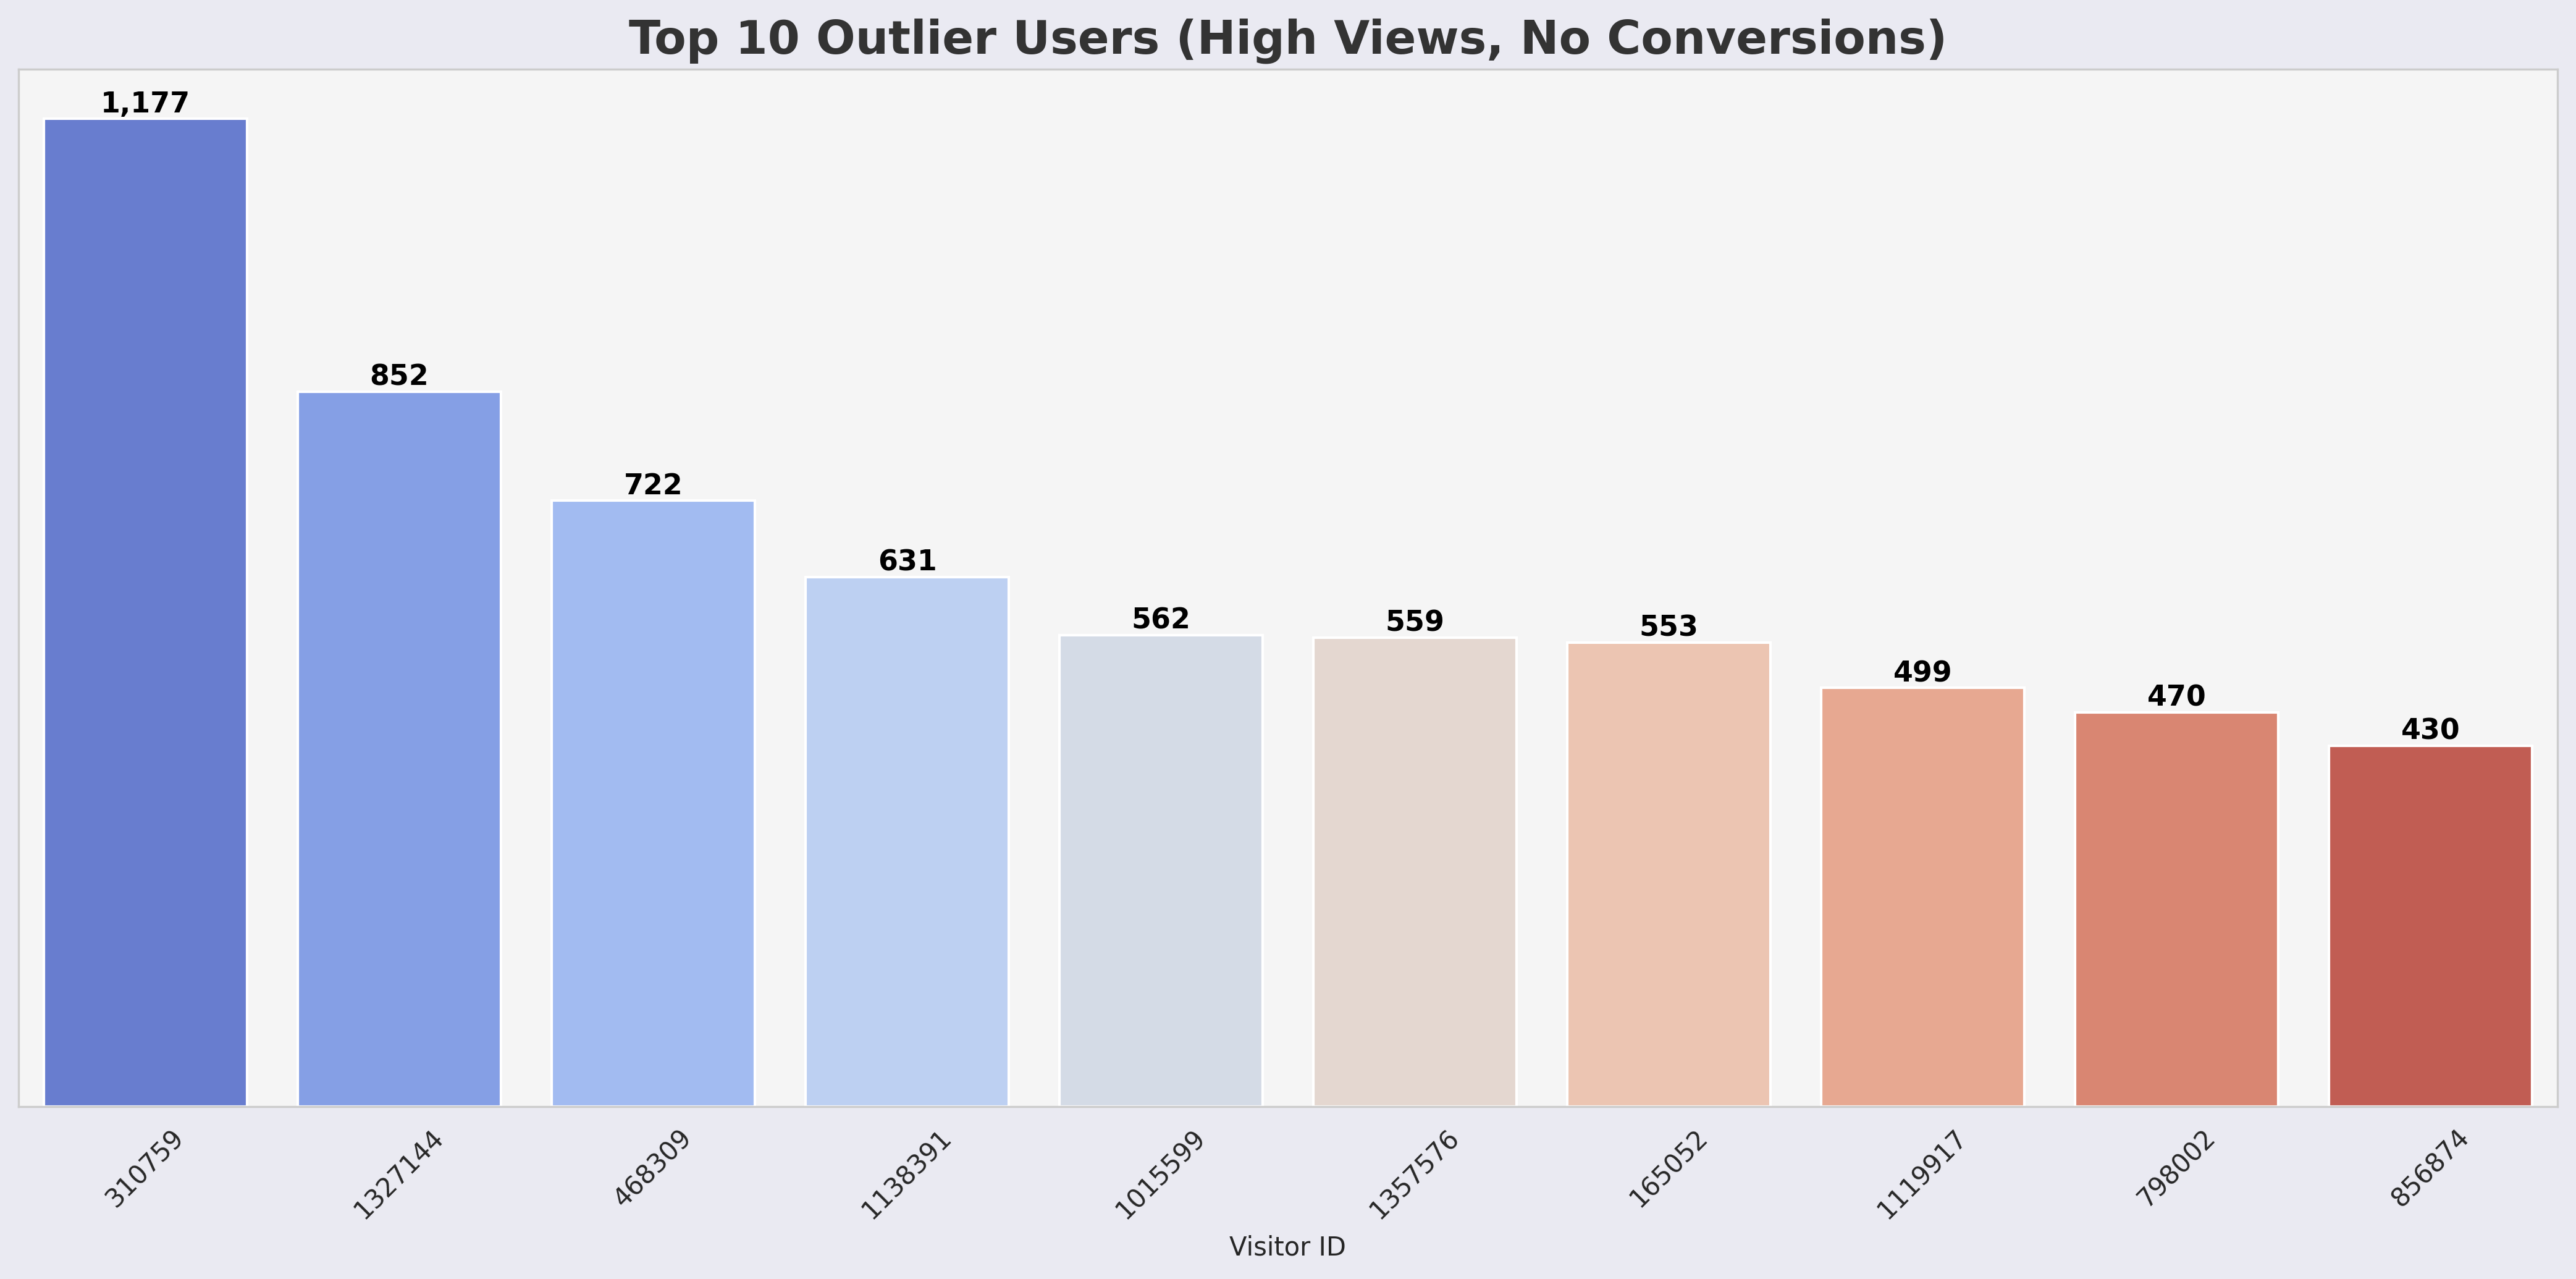

In [ ]:
# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7), dpi=300)

bar = sns.barplot(
    data=top_outliers,
    x='visitorid',
    y='view',
    palette='coolwarm'
)

# Data labels
for p in bar.patches:
    bar.annotate(
        f'{int(p.get_height()):,}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=11, color='black', weight='bold'
    )

# Formatting
plt.title("Top 10 Outlier Users (High Views, No Conversions)", fontsize=18, weight='bold', color='#333')
plt.xlabel("Visitor ID")
plt.ylabel("")
plt.xticks(rotation=45, fontsize=10)
plt.yticks([])

# Background
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().set_facecolor('#eaeaf2')
plt.grid(False)

# Save & Show
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/top_outlier_users.png', dpi=300, bbox_inches='tight')
plt.show()

•	The chart highlights the top 10 visitor IDs with unusually high product view counts but zero conversions (no add-to-cart or transactions).

•	The leading outlier, Visitor ID 310759, recorded an extreme 1,177 views, far exceeding the next highest at 852 views.

•	This pattern suggests possible browsing-only behavior, bot-like activity, or intent-driven searches that failed to convert.

•	Identifying these users is critical for targeted re-engagement strategies, bot detection, and improving conversion funnels.


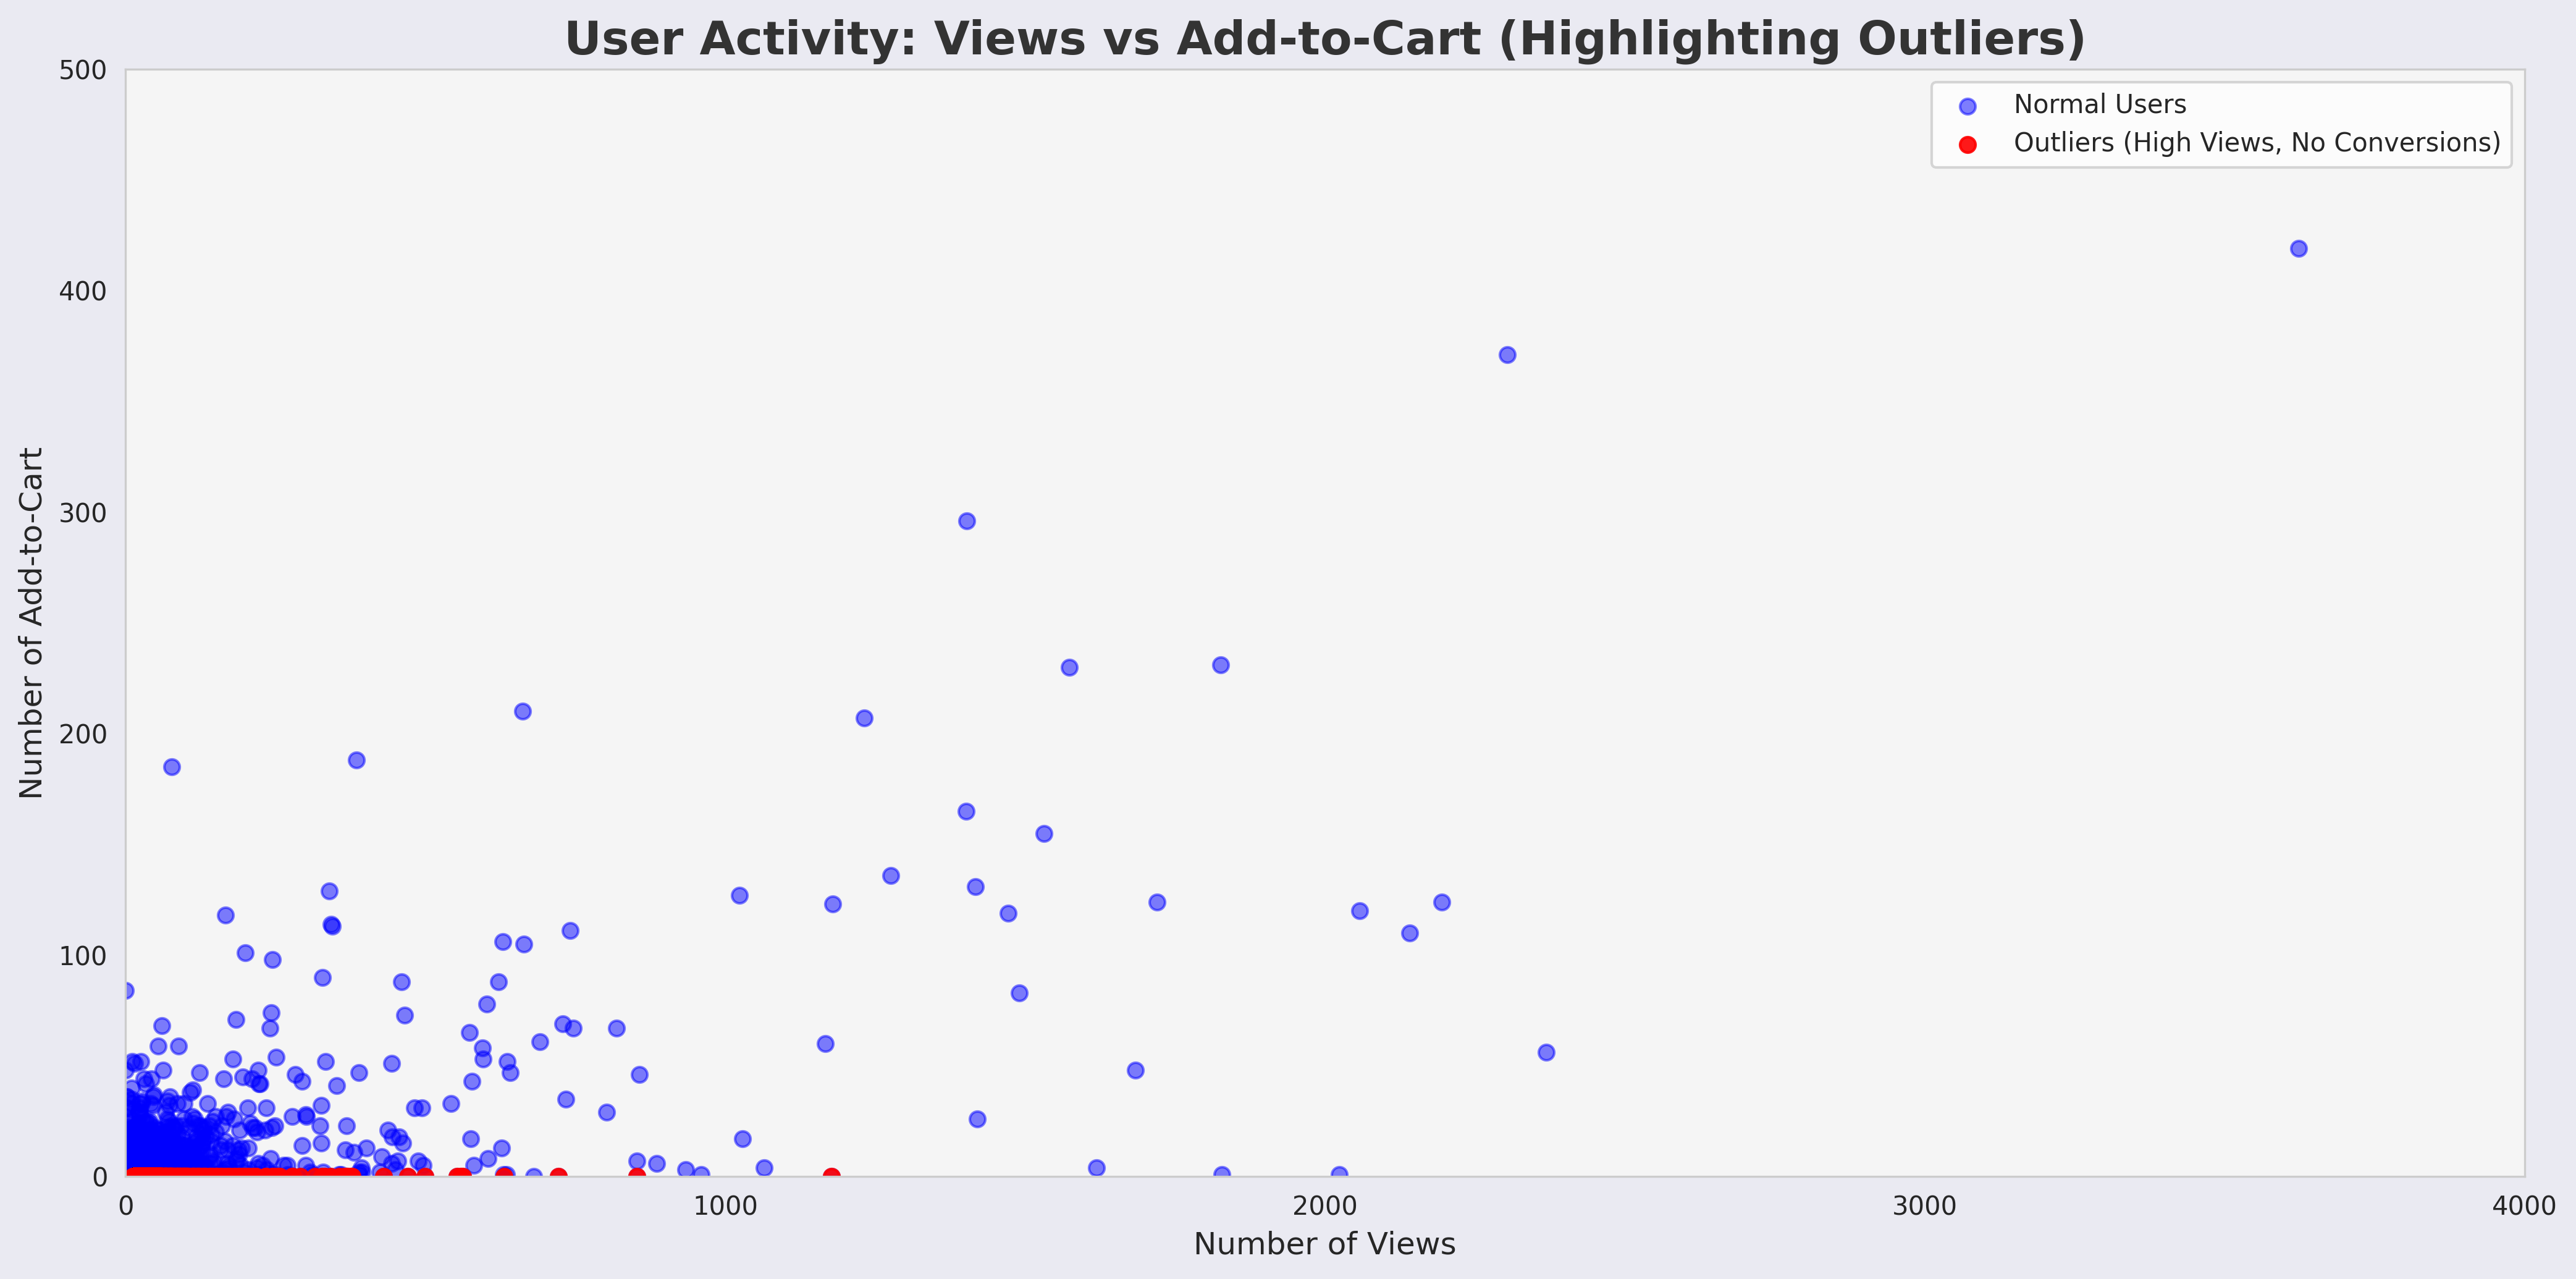

In [ ]:
# Scatter plot: Views vs Add-to-Cart
plt.figure(figsize=(14, 7), dpi=300)
sns.set_style("whitegrid")

# Mark all users
plt.scatter(
    user_actions['view'],
    user_actions['addtocart'],
    alpha=0.5, label='Normal Users', color='blue'
)

# Highlight outliers
plt.scatter(
    outliers['view'],
    outliers['addtocart'],
    alpha=0.9, label='Outliers (High Views, No Conversions)', color='red'
)

# Formatting
plt.title("User Activity: Views vs Add-to-Carts (Highlighting Outliers - Abnormal Users)", fontsize=18, weight='bold', color='#333')
plt.xlabel("Number of Views", fontsize=12)
plt.ylabel("Number of Add-to-Carts", fontsize=12)
plt.legend(loc='upper right', frameon=True)
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().set_facecolor('#eaeaf2')
plt.grid(False)

# Set axis limits and ticks
plt.xlim(0, 4000)
plt.ylim(0, 500)
plt.xticks(range(0, 4001, 1000))
plt.yticks(range(0, 501, 100))

# Save & Show
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/views_vs_addtocart_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

•	Most users cluster in the bottom-left quadrant with fewer than 500 views and 100 add-to-cart actions, indicating typical browsing-to-cart behavior.

•	Outliers are characterized by extremely high views (up to ~3,500) but zero add-to-cart activity, strongly suggesting disengagement or possible automated browsing.

•	The lack of add-to-cart actions from these high-view users skews platform engagement metrics and may signal opportunities for bot filtering or targeted re-engagement.

**Key Takeaway**

•	A small group of visitors accounts for disproportionately high views without converting, indicating potential user disengagement or non-genuine activity that needs targeted action.

•	Outlier detection reveals high-engagement but zero-conversion users, crucial for refining recommendation and fraud detection systems.


### **4. Do abnormal users tend to interact with a specific subset of items or categories?**

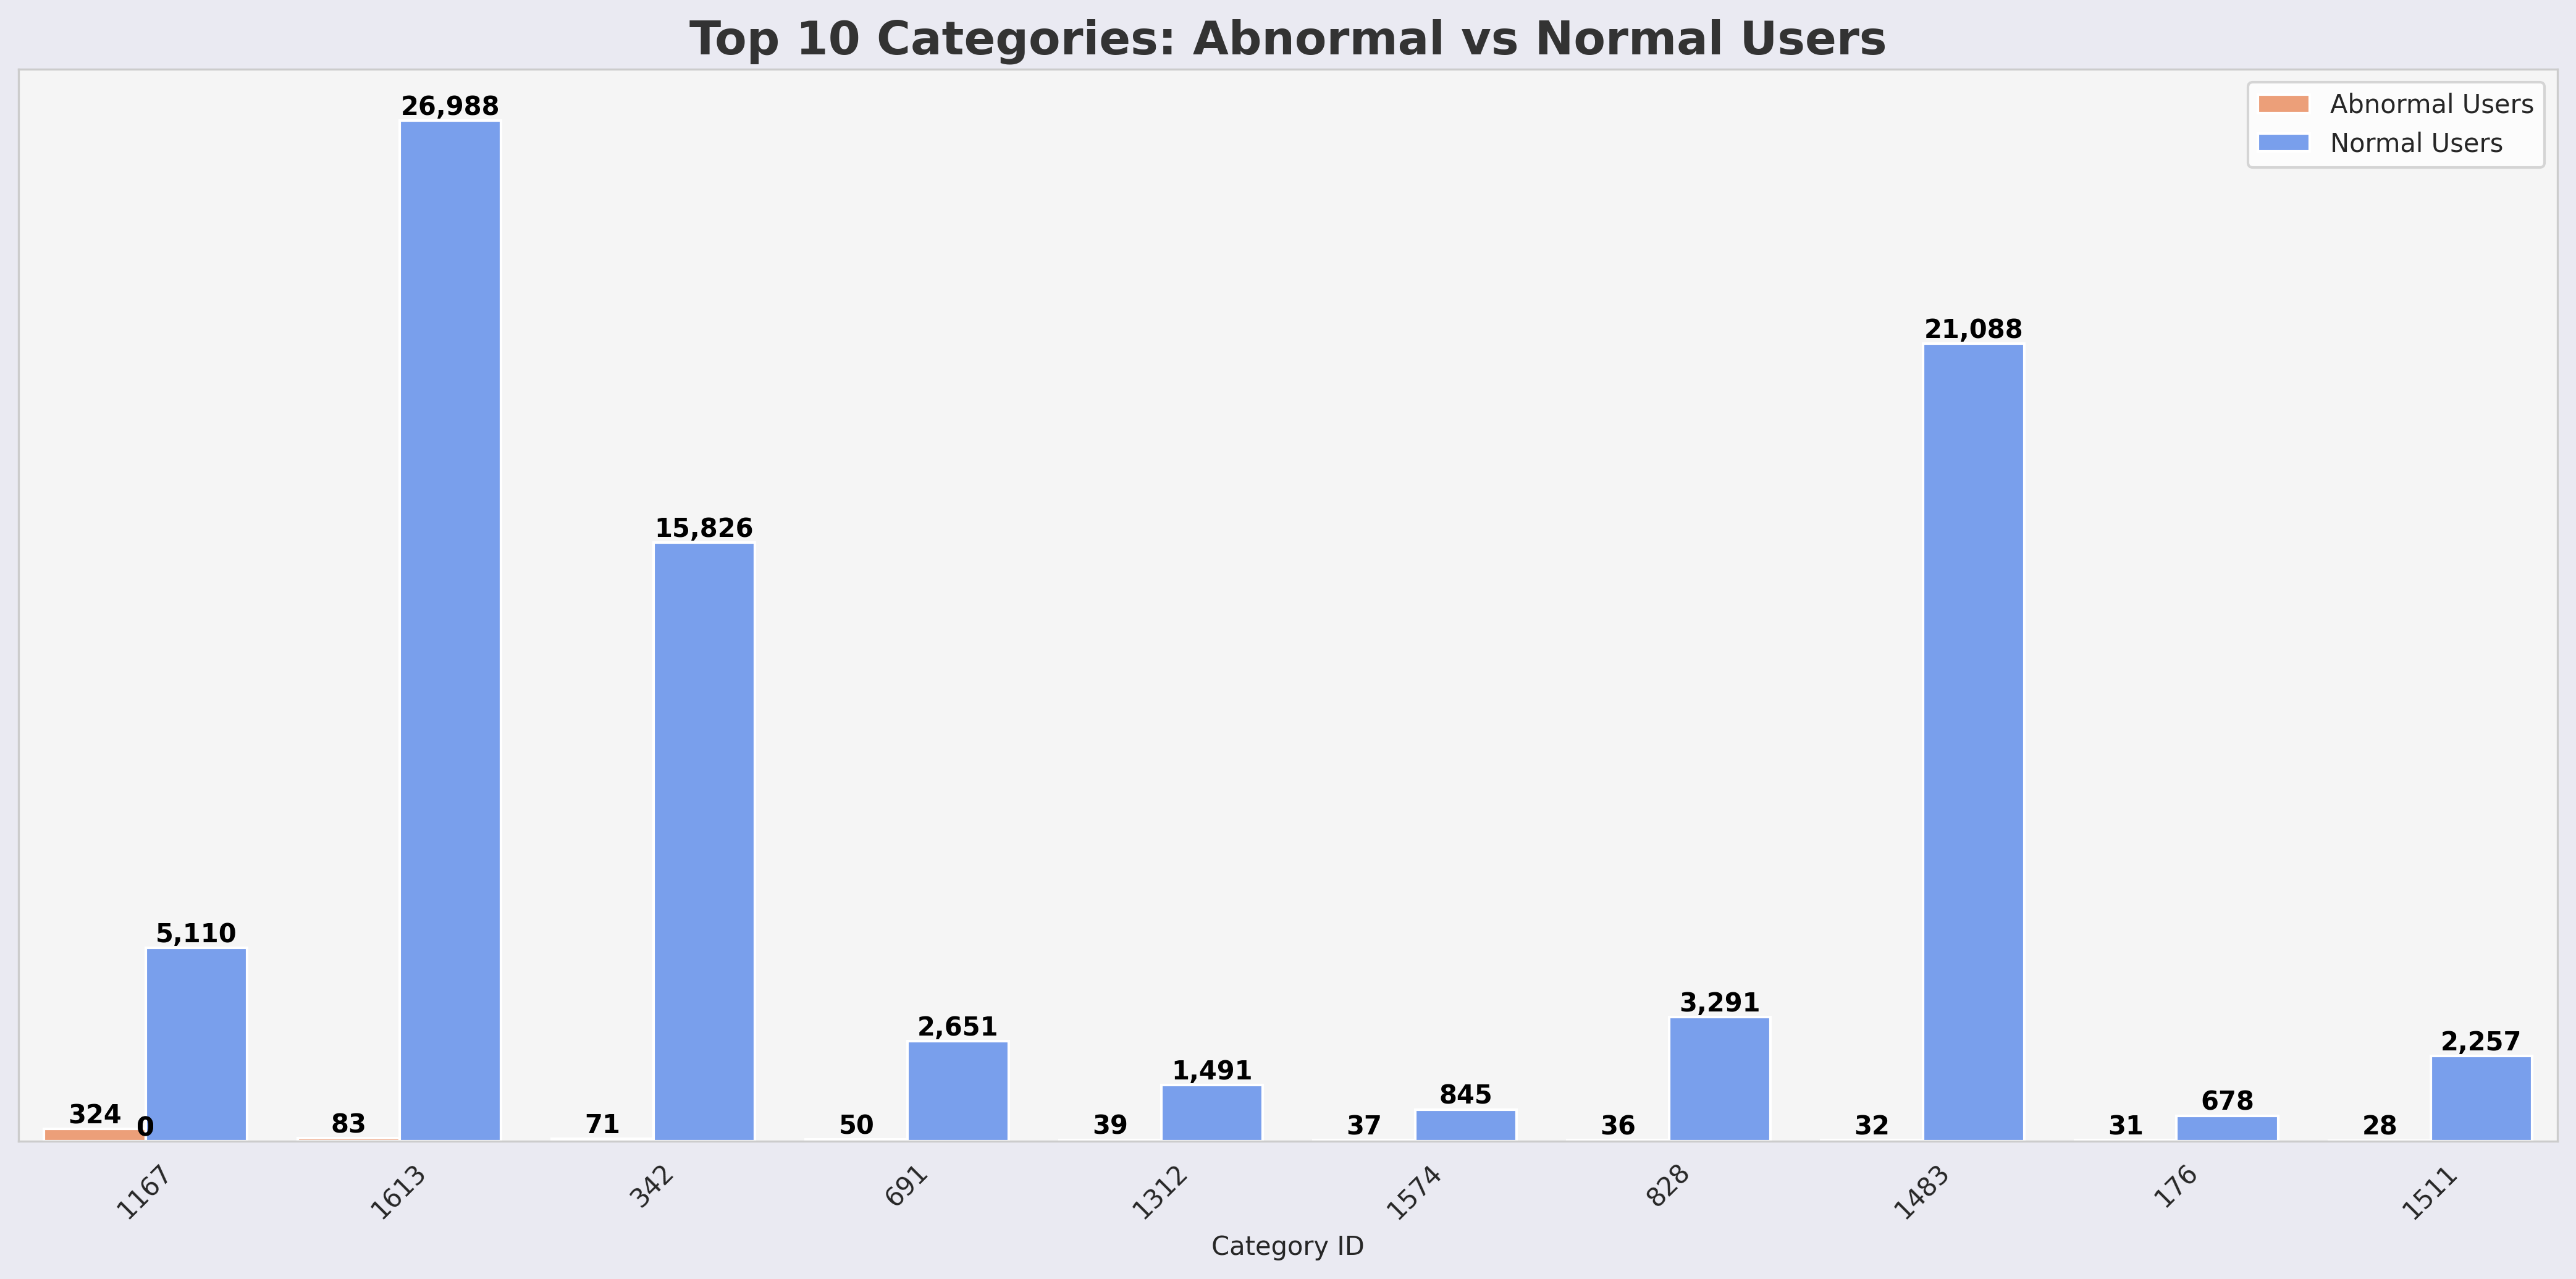

In [ ]:
# --- Separate abnormal & normal users ---
abnormal_ids = top_outliers['visitorid'].unique()
df_abnormal = df_cleaned_final[df_cleaned_final['visitorid'].isin(abnormal_ids)]
df_normal = df_cleaned_final[~df_cleaned_final['visitorid'].isin(abnormal_ids)]

# --- Count top categories for abnormal users ---
abnormal_counts = (
    df_abnormal.groupby('categoryid').size().reset_index(name='count')
    .sort_values(by='count', ascending=False)
    .head(10)
)
abnormal_counts['user_type'] = 'Abnormal Users'

# --- Count top categories for normal users ---
normal_counts = (
    df_normal.groupby('categoryid').size().reset_index(name='count')
)
# Filter to same top abnormal categories for fair comparison
normal_counts = normal_counts[normal_counts['categoryid'].isin(abnormal_counts['categoryid'])]
normal_counts = normal_counts.groupby('categoryid')['count'].sum().reset_index()
normal_counts['user_type'] = 'Normal Users'

# --- Combine ---
cat_compare = pd.concat([abnormal_counts, normal_counts], ignore_index=True)

# --- Sort by abnormal count for plotting ---
order = abnormal_counts['categoryid']

# --- Plot ---
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7), dpi=300)

bar = sns.barplot(
    data=cat_compare,
    x='categoryid', y='count', hue='user_type',
    order=order,
    palette=['#ff9966', '#6699ff']  # warm for abnormal, cool for normal
)

# --- Add labels ---
for p in bar.patches:
    height = p.get_height()
    bar.annotate(f'{int(height):,}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=10, weight='bold', color='black')

# --- Labels & styling ---
plt.title('Top 10 Categories: Abnormal vs Normal Users', fontsize=18, weight='bold', color='#333')
plt.xlabel('Category ID')
plt.ylabel('')
plt.yticks([])
plt.xticks(rotation=45)
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().set_facecolor('#eaeaf2')
plt.grid(False)
plt.legend(title='', loc='upper right')

# Save & show
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/category_distribution_abnormal_vs_normal.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# --- Percentage share calculation ---
# Combine counts into one DataFrame and pivot for comparison
share_table = cat_compare.pivot_table(
    index='categoryid',
    columns='user_type',
    values='count',
    fill_value=0
).reset_index()

# Convert counts to integers
share_table['Abnormal Users'] = share_table['Abnormal Users'].astype(int)
share_table['Normal Users'] = share_table['Normal Users'].astype(int)

# Calculate percentage share for each group
total_abnormal = share_table['Abnormal Users'].sum()
total_normal = share_table['Normal Users'].sum()

share_table['Abnormal %'] = (share_table['Abnormal Users'] / total_abnormal * 100).round(2)
share_table['Normal %'] = (share_table['Normal Users'] / total_normal * 100).round(2)

# Sort by Abnormal % descending
share_table = share_table.sort_values(by='Abnormal %', ascending=False)

print("\n--- Category Share Comparison ---")
share_table


--- Category Share Comparison ---


user_type,categoryid,Abnormal Users,Normal Users,Abnormal %,Normal %
0,1167,324,5110,44.32,6.37
5,1613,83,26988,11.35,33.64
7,342,71,15826,9.71,19.73
8,691,50,2651,6.84,3.30
1,1312,39,1491,5.34,1.86
4,1574,37,845,5.06,1.05
9,828,36,3291,4.92,4.10
2,1483,32,21088,4.38,26.29
6,176,31,678,4.24,0.85
3,1511,28,2257,3.83,2.81


Abnormal users heavily over-engage with niche categories like 1167, while avoiding major categories that dominate normal user activity.

This pattern suggests deliberate, non-organic browsing behavior.

**Key Takeaway**

Abnormal activity is highly concentrated, ignoring mainstream categories favored by normal users.

### **5. What is the conversion funnel across the platform: from view → add to cart → transaction, and how does it vary across item categories or user types?**

In [ ]:
# --- Step 1: Get unique (visitorid, itemid) pairs for each stage ---
views = df_cleaned_final[df_cleaned_final['event'] == 'view'][['visitorid', 'itemid']].drop_duplicates()
addtocart = df_cleaned_final[df_cleaned_final['event'] == 'addtocart'][['visitorid', 'itemid']].drop_duplicates()
transactions = df_cleaned_final[df_cleaned_final['event'] == 'transaction'][['visitorid', 'itemid']].drop_duplicates()

# --- Step 2: Enforce sequential flow ---
addtocart = addtocart.merge(views, on=['visitorid', 'itemid'], how='inner')
transactions = transactions.merge(addtocart, on=['visitorid', 'itemid'], how='inner')

# --- Step 3: Funnel data ---
funnel_data = pd.DataFrame({
    'Stage': ['View', 'Add to Cart', 'Transaction'],
    'Count': [len(views), len(addtocart), len(transactions)]
})
funnel_data['% of Views'] = (funnel_data['Count'] / funnel_data['Count'].iloc[0] * 100).round(2)

# --- Step 4: Custom labels ---
custom_labels = [
    f"{stage}: {count:,} ({pct}%)"
    for stage, count, pct in zip(funnel_data['Stage'], funnel_data['Count'], funnel_data['% of Views'])
]

# Text position: First label inside, rest outside
text_positions = ["inside"] + ["outside"] * (len(custom_labels) - 1)

fig = go.Figure(go.Funnel(
    y=funnel_data['Stage'],
    x=funnel_data['Count'],
    text=custom_labels,
    textposition=text_positions,    # Stage-specific positions
    textinfo="text",
    textfont=dict(size=16, color="black"),
    marker=dict(color=['#f77f00', '#fcbf49', '#90be6d']),
    connector={"line": {"color": "gray", "dash": "solid"}}
))

fig.update_layout(
    title=dict(
        text="E-Commerce Conversion Funnel",
        x=0.5,  # Center-align
        font=dict(size=20, color='#333', family='Arial Black')
    ),
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#eaeaf2',
    font=dict(size=12, color='#333'),
    margin=dict(l=40, r=80, t=80, b=40),
    yaxis=dict(showticklabels=False)  # Hide y-axis ticks
)

fig.show()

# Save interactive HTML file
fig.write_html("/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/overall_conversion_funnel.png")

•	The funnel reveals a significant drop-off from product views to subsequent actions.

•	Out of 2,132,103 unique item views, only 49,492 (2.32%) progressed to the add-to-cart stage, indicating low initial engagement beyond browsing.

•	The final conversion to purchases is even lower, with 17,347 transactions, representing just 0.81% of all views.

•	This steep attrition suggests potential issues in product appeal, pricing, or checkout experience.

### **6. When do users engage most with the platform, and does this affect conversions?**

/tmp/ipython-input-2556769559.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=hourly_df, x='hour', y='view_count', palette='coolwarm')


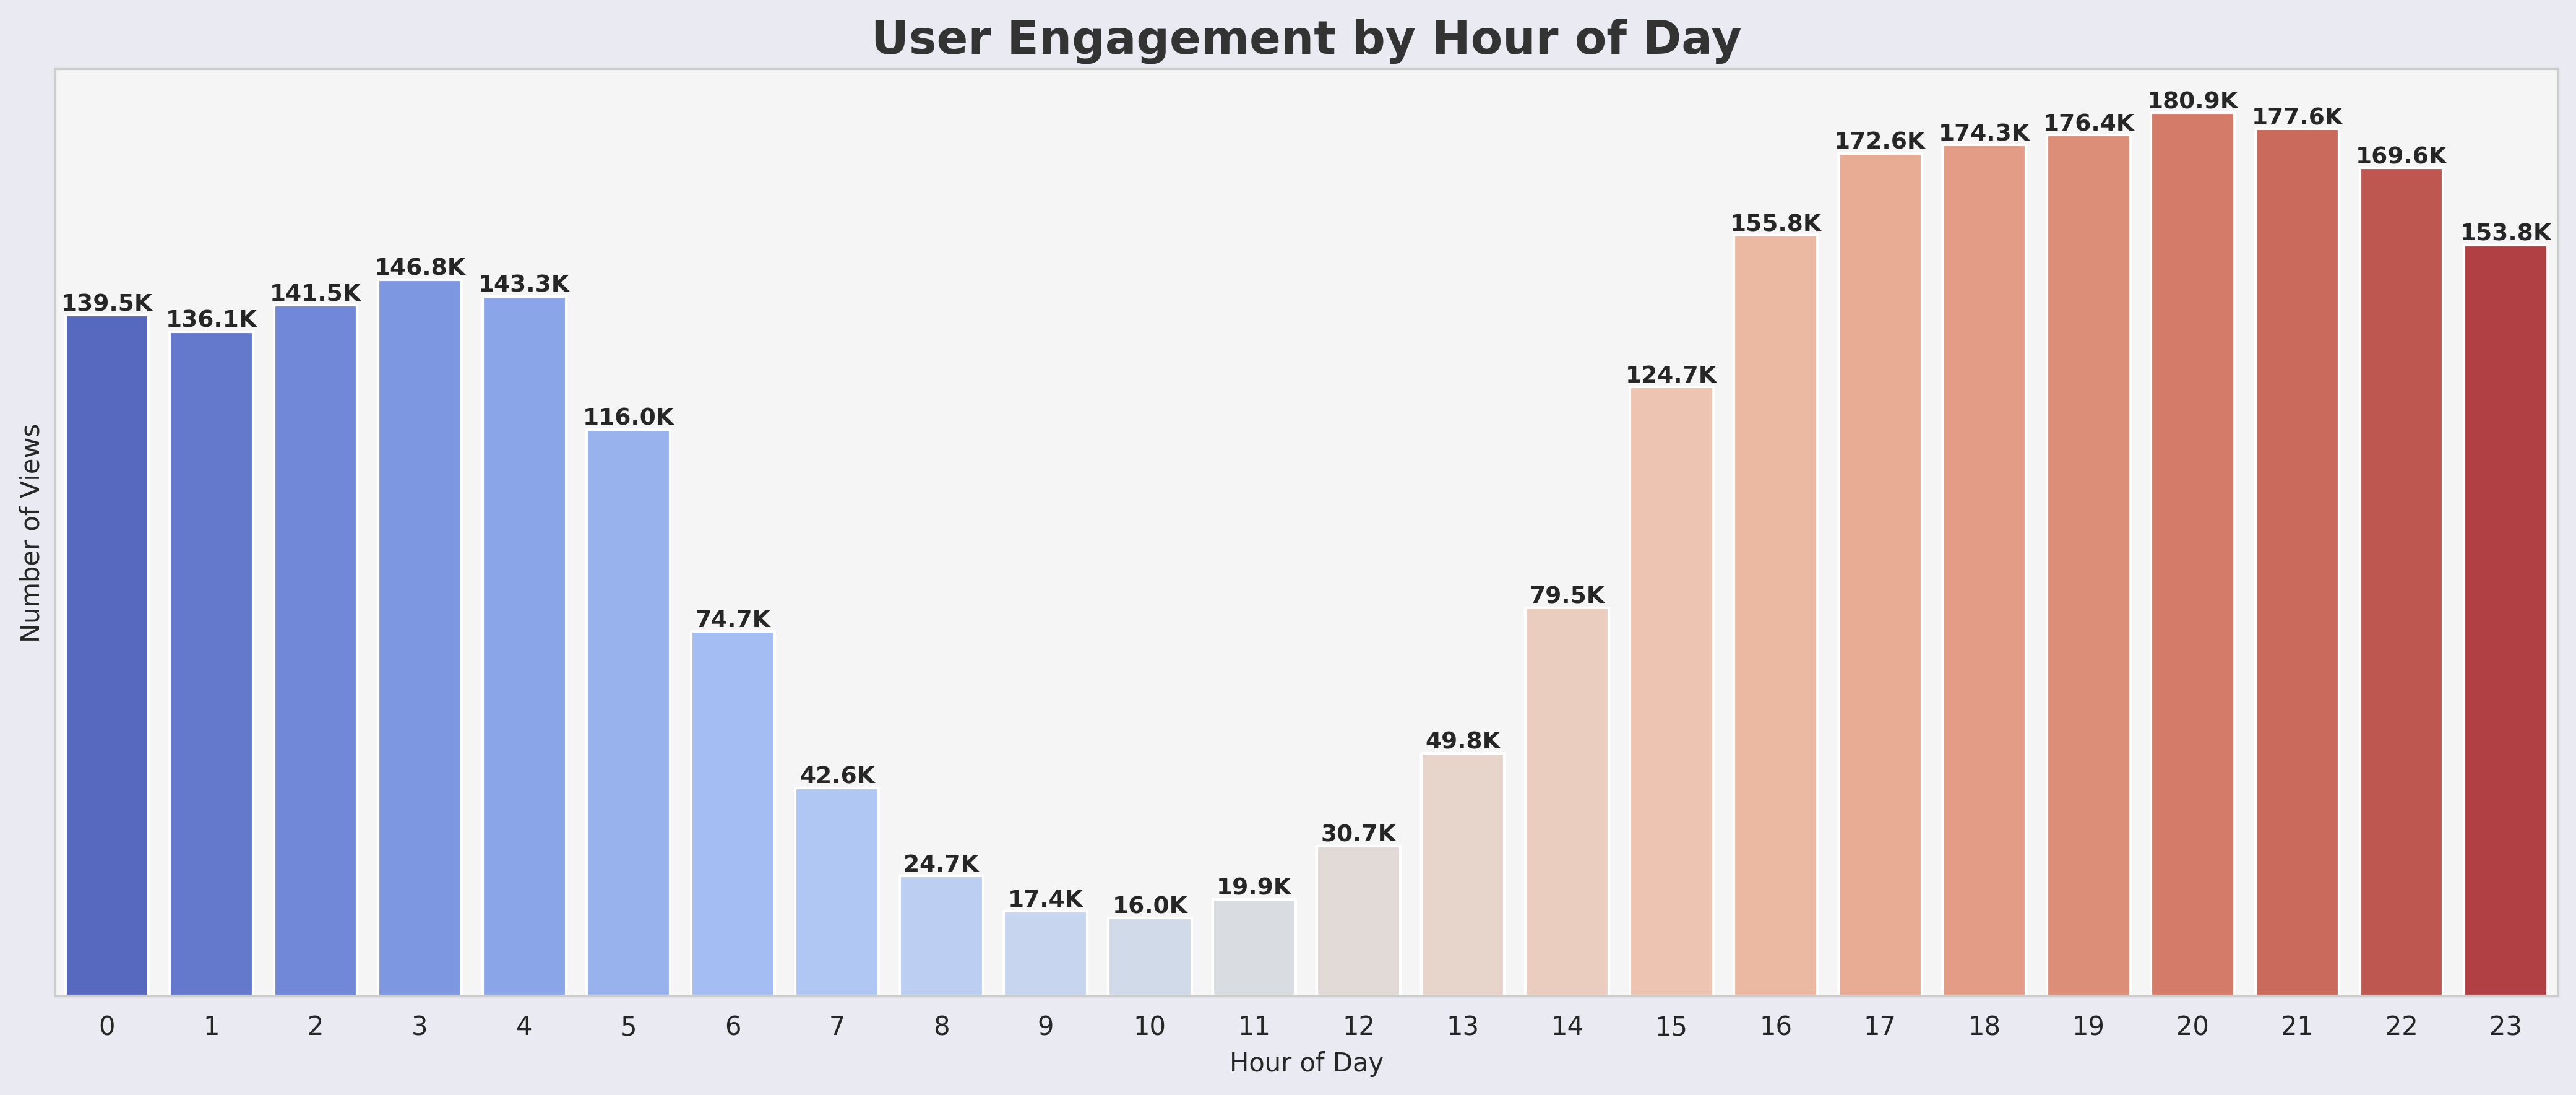

/tmp/ipython-input-2556769559.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=hourly_df, x='hour', y='conversion_rate', palette='viridis')


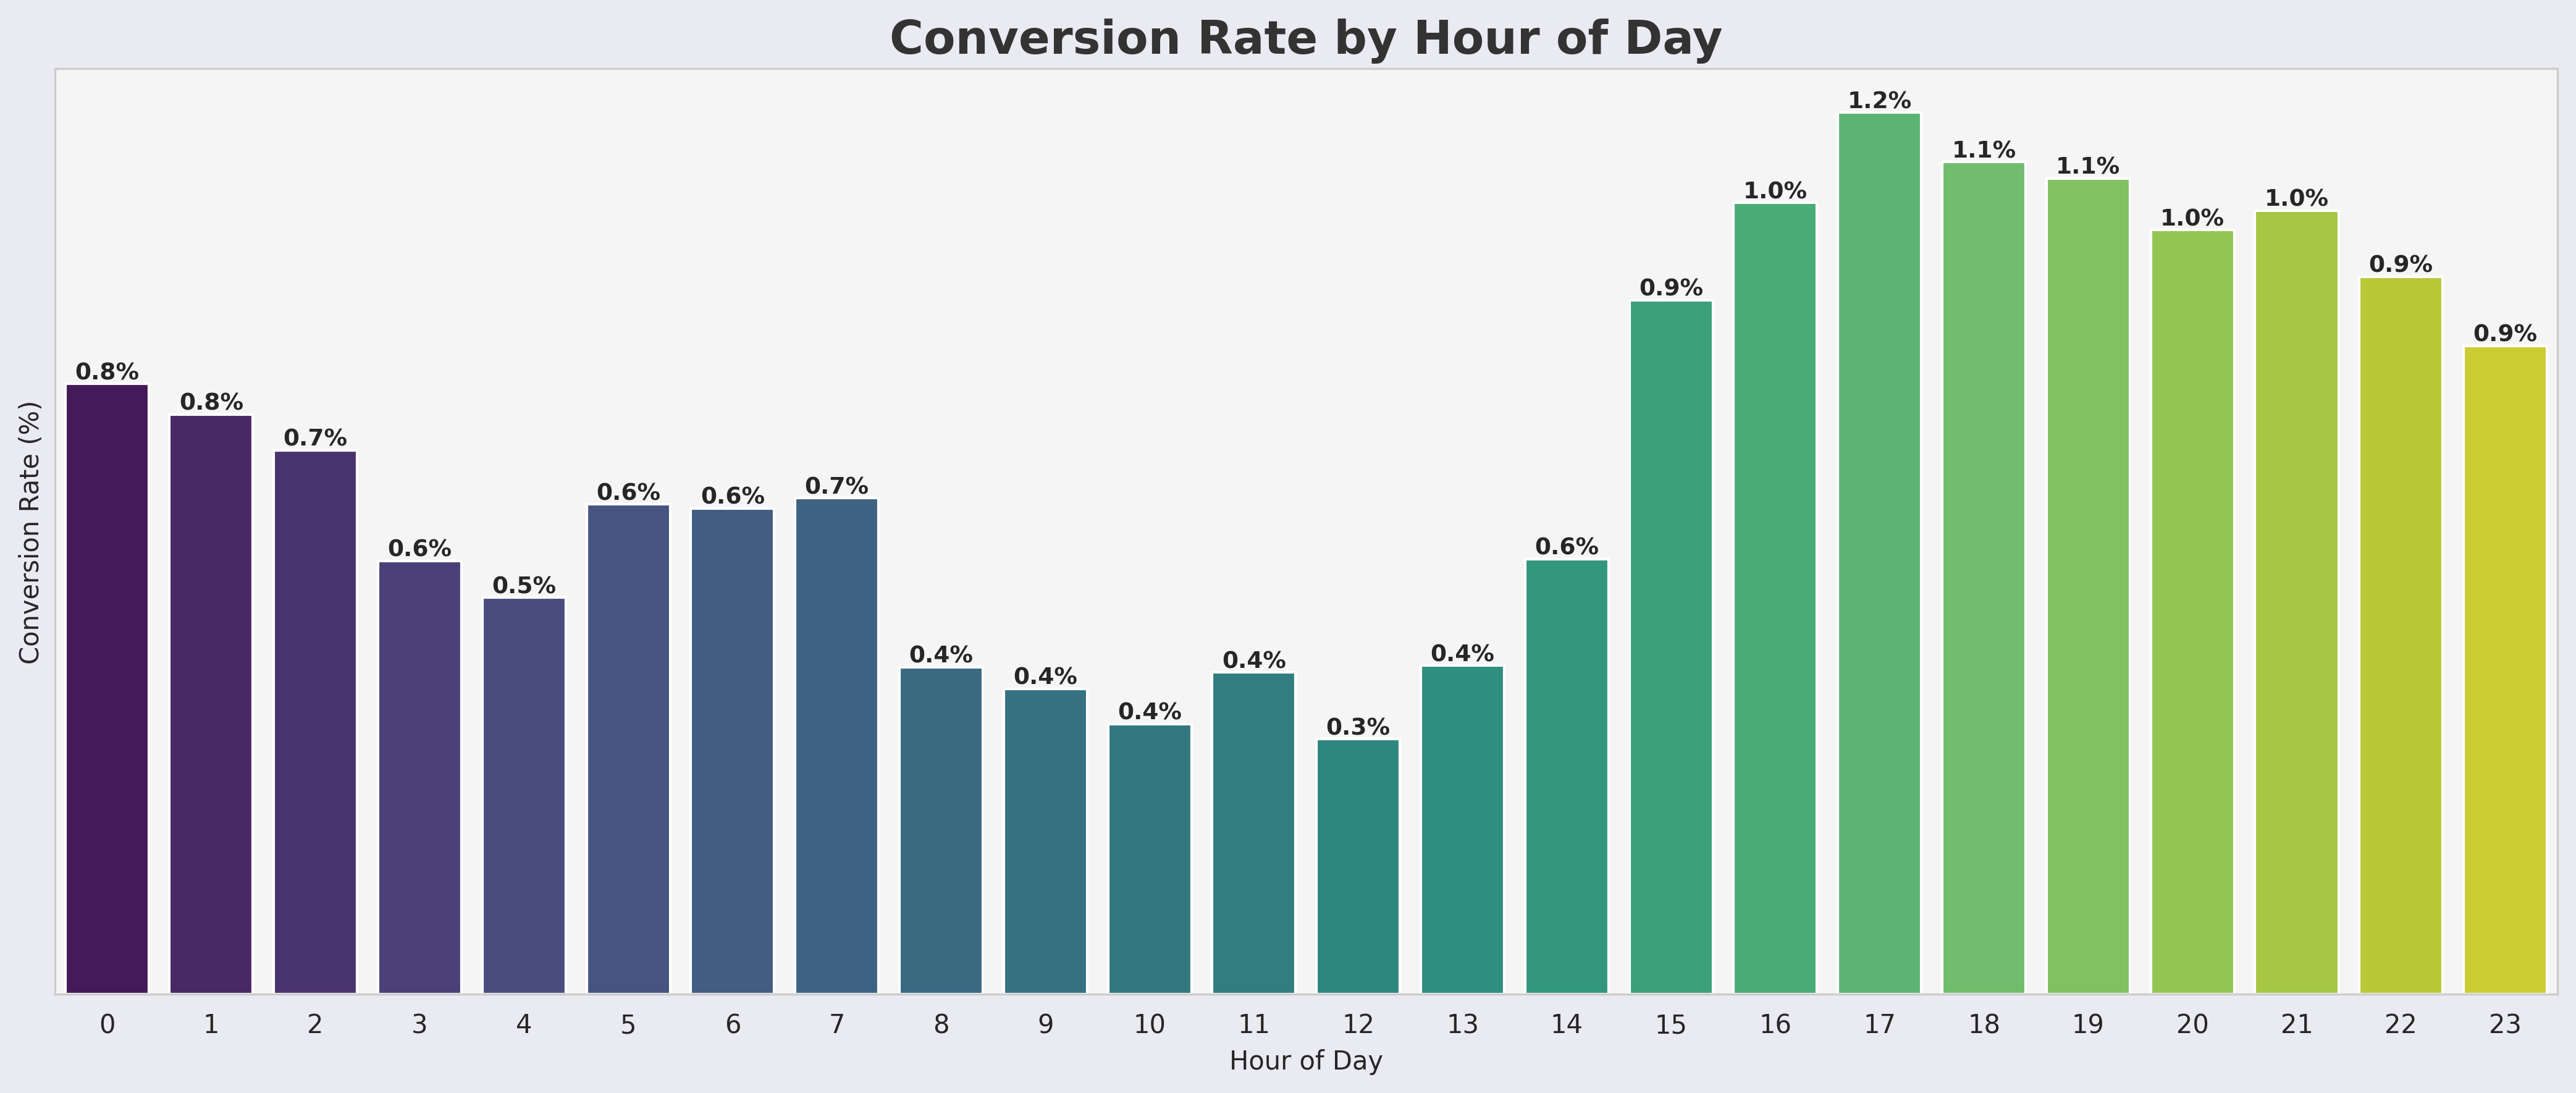

/tmp/ipython-input-2556769559.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=daily_df, x='day_of_week', y='view_count', order=day_order, palette='coolwarm')


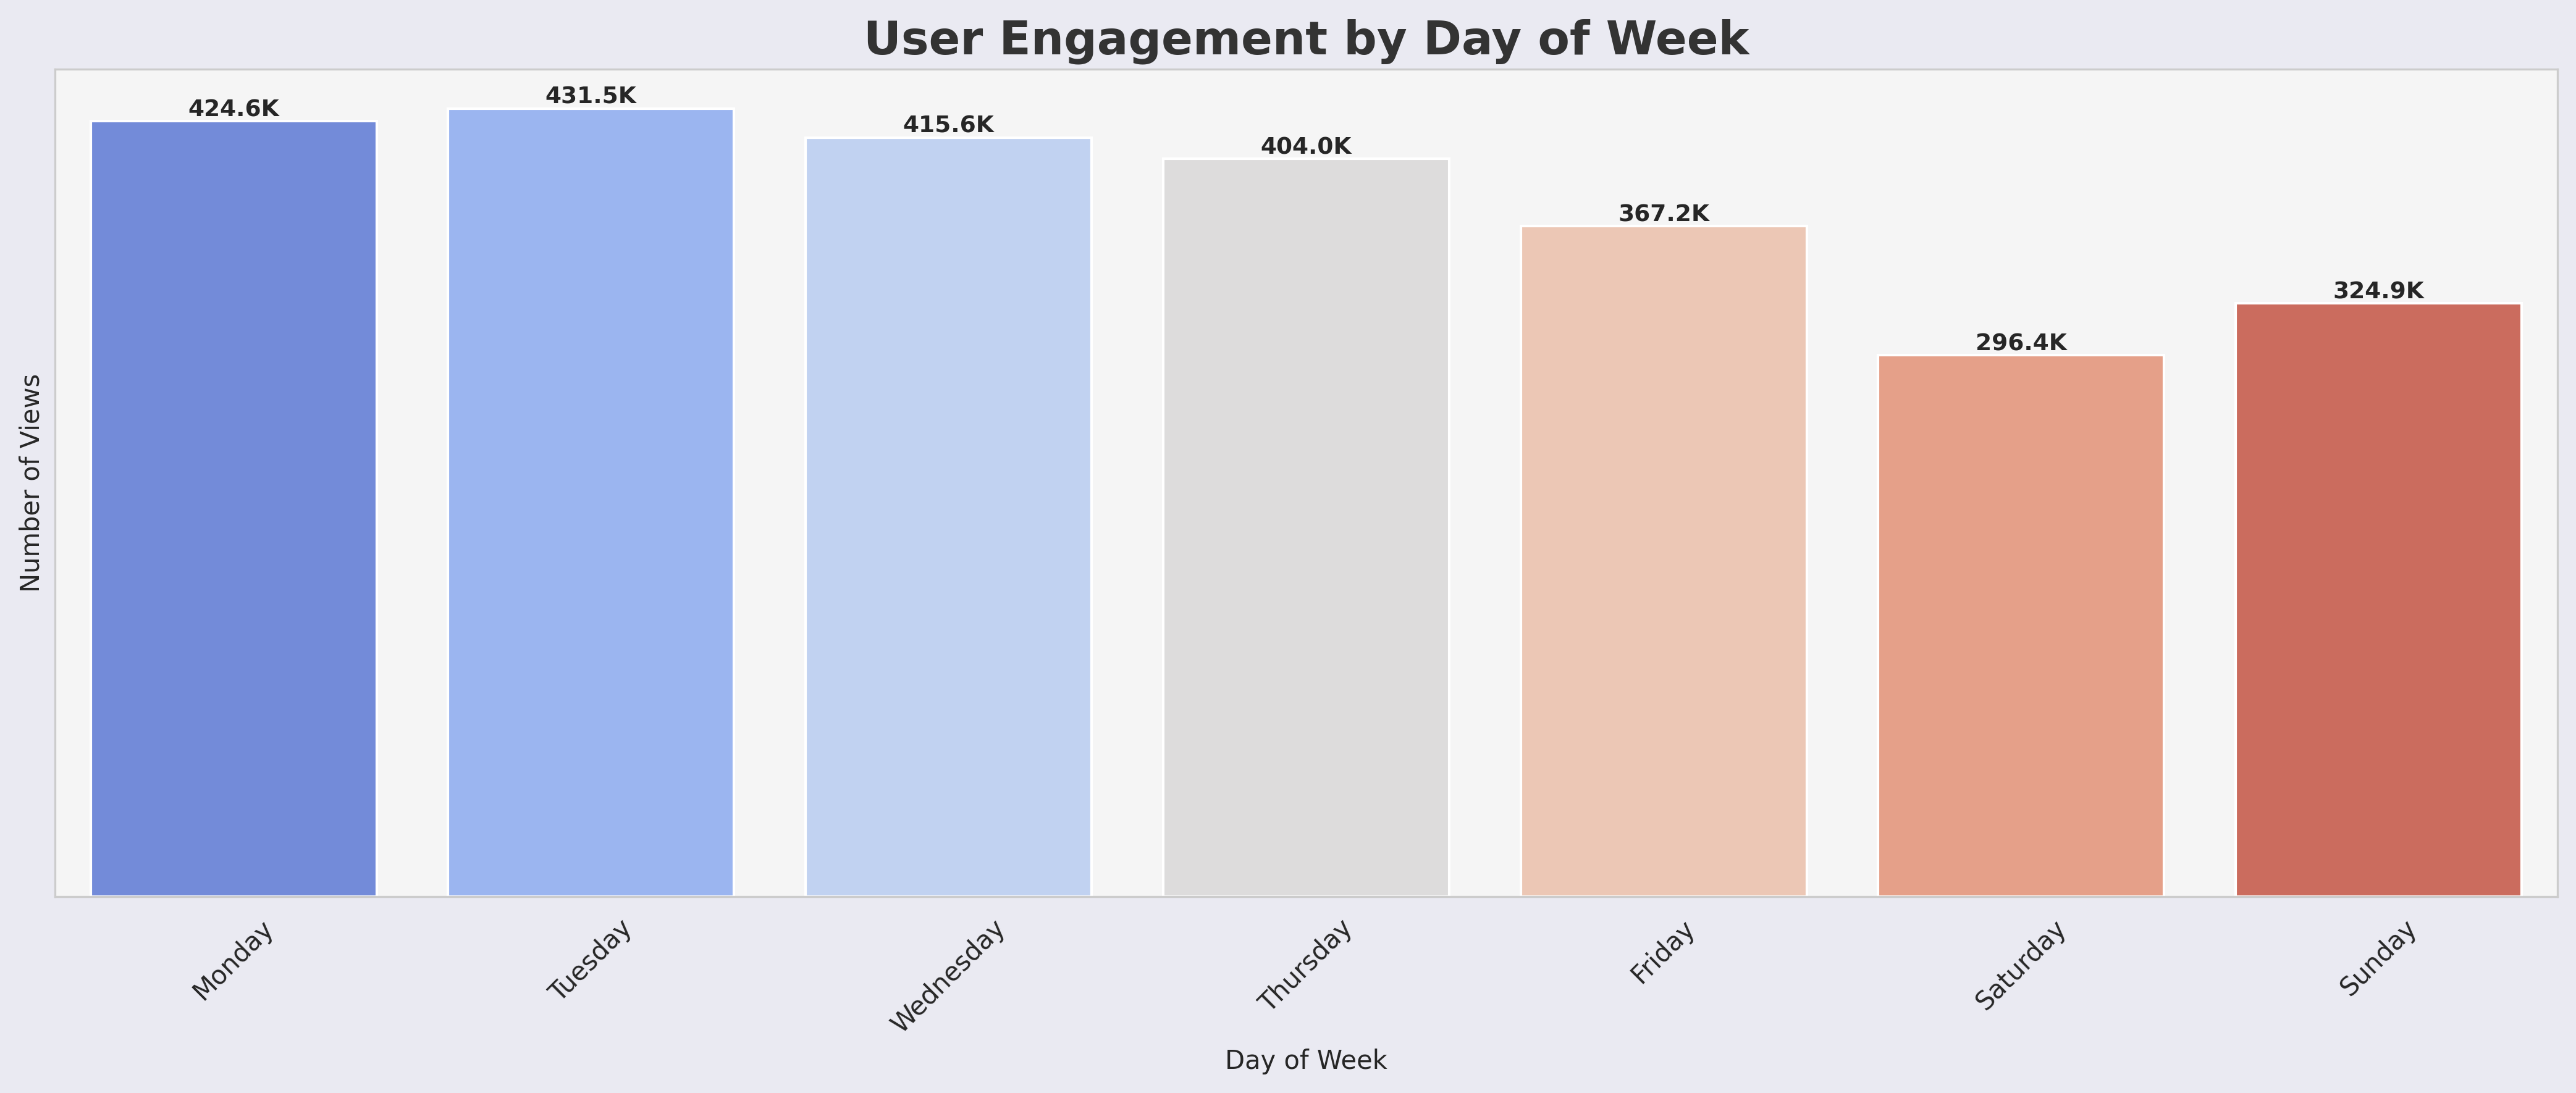

/tmp/ipython-input-2556769559.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=daily_df, x='day_of_week', y='conversion_rate', order=day_order, palette='viridis')


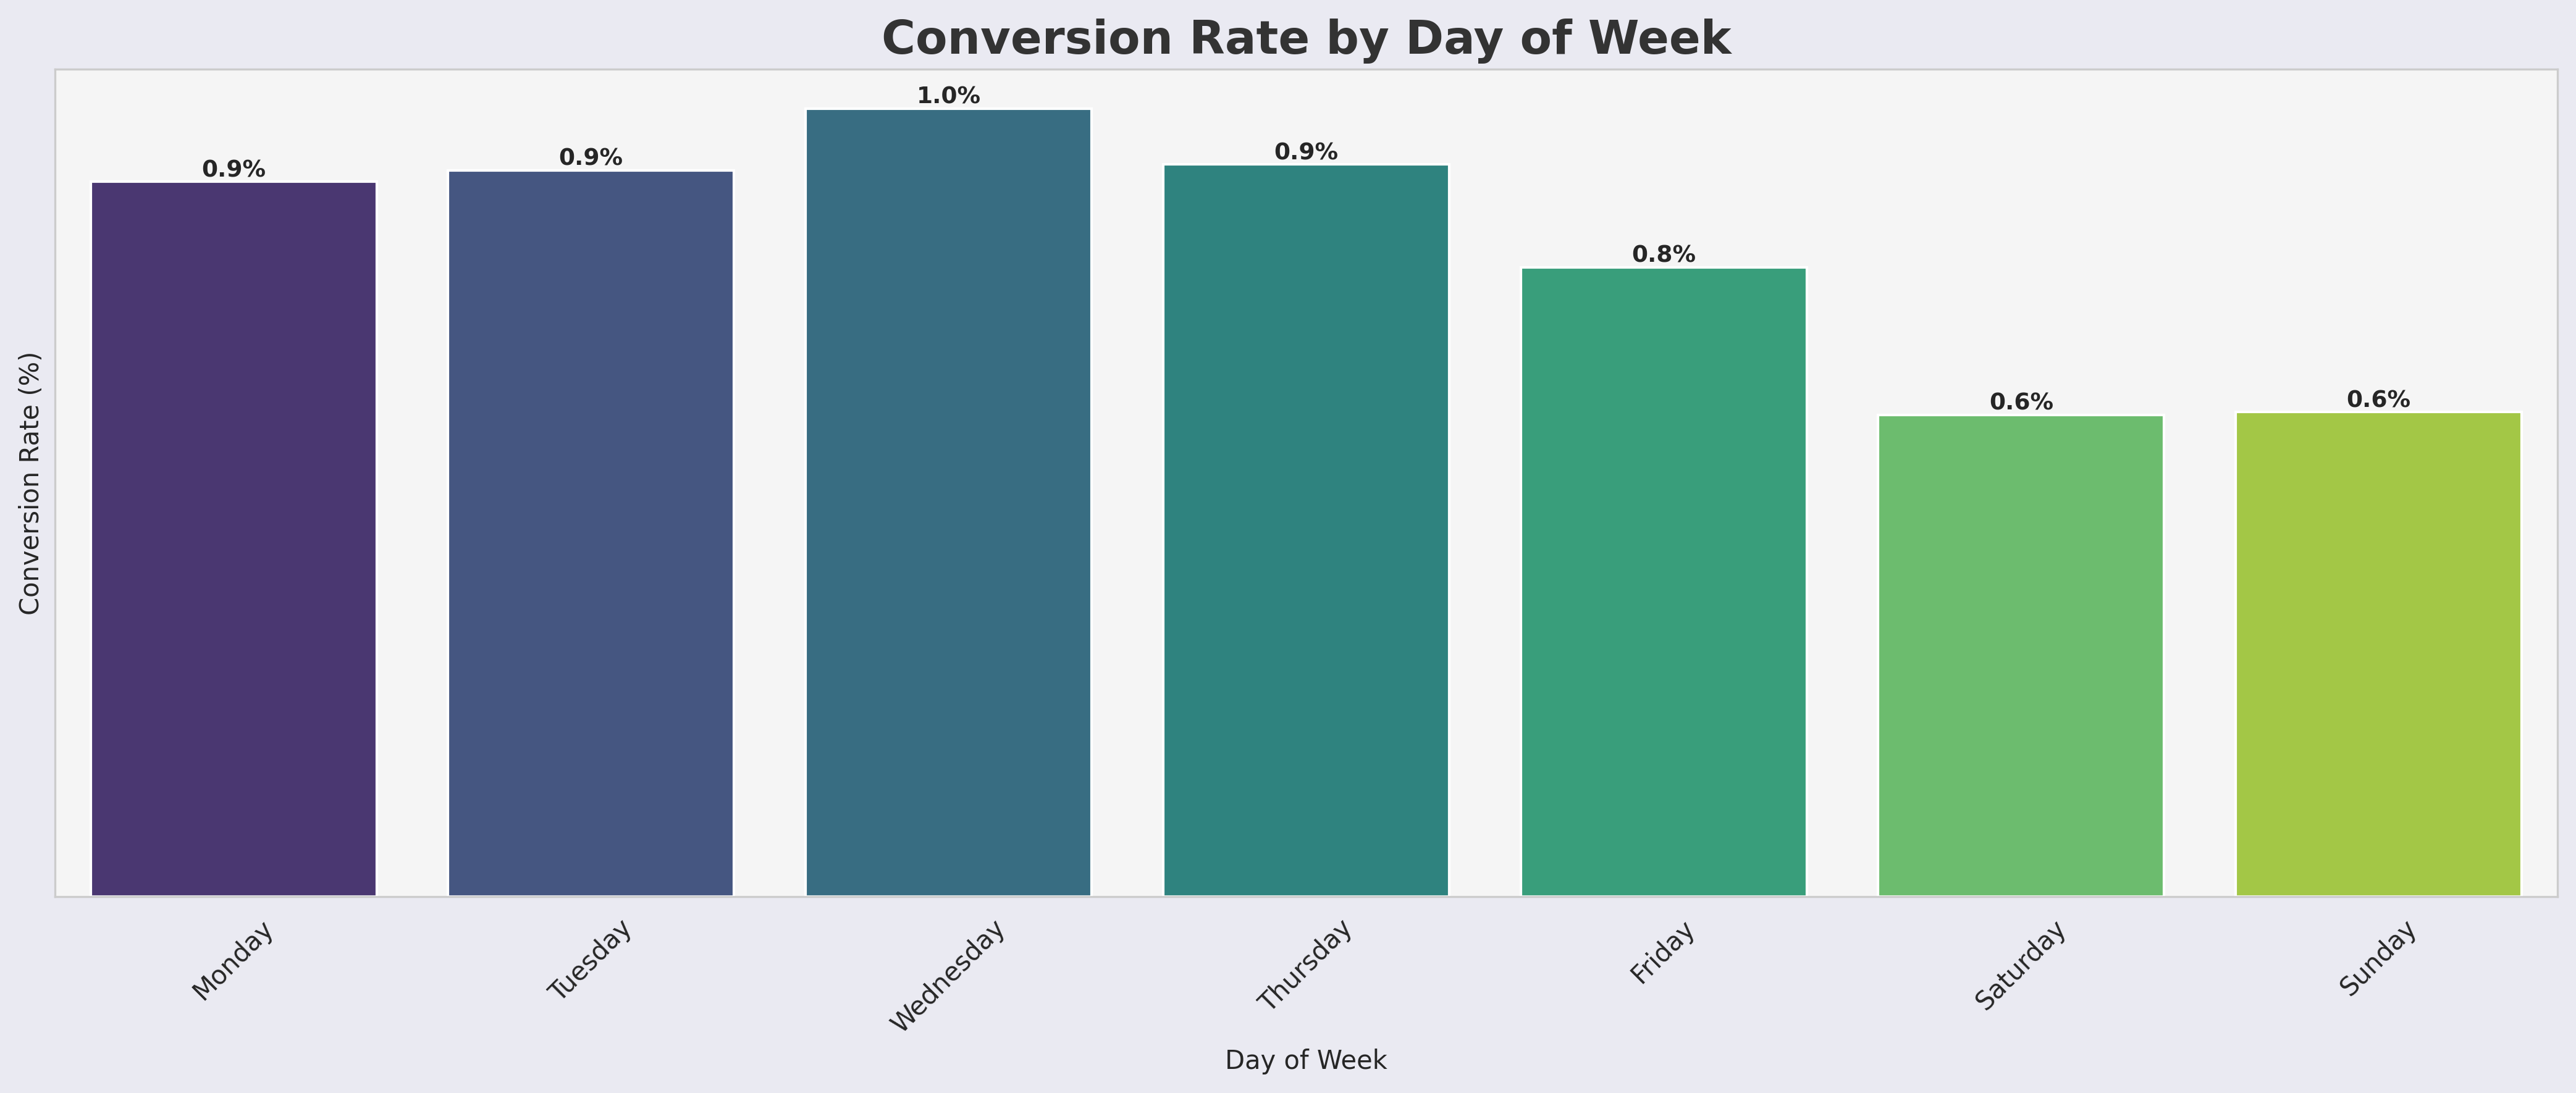

In [ ]:
# Prepare Data
df_time = df_cleaned_final.copy()
df_time['timestamp'] = pd.to_datetime(df_time['timestamp'])

# Extract time features
df_time['hour'] = df_time['timestamp'].dt.hour
df_time['day_of_week'] = df_time['timestamp'].dt.day_name()

# Order days for plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Engagement by Hour
hourly_views = df_time[df_time['event'] == 'view'].groupby('hour').size().reset_index(name='view_count')
hourly_transactions = df_time[df_time['event'] == 'transaction'].groupby('hour').size().reset_index(name='transaction_count')

hourly_df = hourly_views.merge(hourly_transactions, on='hour', how='left').fillna(0)
hourly_df['conversion_rate'] = (hourly_df['transaction_count'] / hourly_df['view_count']) * 100

# Engagement by Day
daily_views = df_time[df_time['event'] == 'view'].groupby('day_of_week').size().reset_index(name='view_count')
daily_transactions = df_time[df_time['event'] == 'transaction'].groupby('day_of_week').size().reset_index(name='transaction_count')

daily_df = daily_views.merge(daily_transactions, on='day_of_week', how='left').fillna(0)
daily_df['conversion_rate'] = (daily_df['transaction_count'] / daily_df['view_count']) * 100
daily_df['day_of_week'] = pd.Categorical(daily_df['day_of_week'], categories=day_order, ordered=True)

# Plot: Engagement by Hour
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6), dpi=300)
bar = sns.barplot(data=hourly_df, x='hour', y='view_count', palette='coolwarm')

# Add labels
for p in bar.patches:
    bar.annotate(f'{int(p.get_height())/1e3:.1f}K',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9, weight='bold')

plt.title("User Engagement by Hour of Day", fontsize=18, weight='bold', color='#333')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Views")
plt.yticks([])
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().set_facecolor('#eaeaf2')
plt.grid(False)
plt.tight_layout()
plt.savefig("hourly_engagement.png", dpi=300, bbox_inches='tight')
plt.show()

plt.savefig('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/User_Engagement_by_Hour_of_Day.png',
            dpi=300, bbox_inches='tight')

# Plot: Conversion Rate by Hour
plt.figure(figsize=(14, 6), dpi=300)
bar = sns.barplot(data=hourly_df, x='hour', y='conversion_rate', palette='viridis')

for p in bar.patches:
    bar.annotate(f'{p.get_height():.1f}%',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9, weight='bold')

plt.title("Conversion Rate by Hour of Day", fontsize=18, weight='bold', color='#333')
plt.xlabel("Hour of Day")
plt.ylabel("Conversion Rate (%)")
plt.yticks([])
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().set_facecolor('#eaeaf2')
plt.grid(False)
plt.tight_layout()
plt.savefig("hourly_conversion.png", dpi=300, bbox_inches='tight')
plt.show()

plt.savefig('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/Conversion_Rate_by_Hour_of_Day.png',
            dpi=300, bbox_inches='tight')

# Plot: Engagement by Day of Week
plt.figure(figsize=(14, 6), dpi=300)
bar = sns.barplot(data=daily_df, x='day_of_week', y='view_count', order=day_order, palette='coolwarm')

for p in bar.patches:
    bar.annotate(f'{int(p.get_height())/1e3:.1f}K',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9, weight='bold')

plt.title("User Engagement by Day of Week", fontsize=18, weight='bold', color='#333')
plt.xlabel("Day of Week")
plt.ylabel("Number of Views")
plt.xticks(rotation=45)
plt.yticks([])
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().set_facecolor('#eaeaf2')
plt.grid(False)
plt.tight_layout()
plt.savefig("daily_engagement.png", dpi=300, bbox_inches='tight')
plt.show()

plt.savefig('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/User_Engagement_by_Day_of_Week.png',
            dpi=300, bbox_inches='tight')

# Plot: Conversion Rate by Day of Week
plt.figure(figsize=(14, 6), dpi=300)
bar = sns.barplot(data=daily_df, x='day_of_week', y='conversion_rate', order=day_order, palette='viridis')

for p in bar.patches:
    bar.annotate(f'{p.get_height():.1f}%',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9, weight='bold')

plt.title("Conversion Rate by Day of Week", fontsize=18, weight='bold', color='#333')
plt.xlabel("Day of Week")
plt.ylabel("Conversion Rate (%)")
plt.xticks(rotation=45)
plt.yticks([])
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().set_facecolor('#eaeaf2')
plt.grid(False)
plt.tight_layout()
plt.savefig("daily_conversion.png", dpi=300, bbox_inches='tight')
plt.show()

plt.savefig('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/Conversion_Rate_by_Day_of_Week.png',
            dpi=300, bbox_inches='tight')

## **BEGIN PREDICTIVE MODELLING**

---



### **Run Some Quick Checks**

In [7]:
df_cleaned_final.isna().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733150
categoryid,1851592
available,1082839
parentid,1851592


In [8]:
df_cleaned_predict = df_cleaned_final.copy()
df_cleaned_predict['categoryid'] = df_cleaned_predict['categoryid'].fillna('Unknown_CatID').astype(str)

In [9]:
df_cleaned_predict

,timestamp,visitorid,event,itemid,transactionid,categoryid,available,parentid
0,2015-08-20 20:38:19.422,1238415,view,308519,NaN,Unknown_CatID,0,NaN
1,2015-06-17 03:51:36.952,177912,view,308538,NaN,Unknown_CatID,0,NaN
2,2015-06-28 19:07:58.978,264504,view,308538,NaN,Unknown_CatID,0,NaN
3,2015-07-19 03:01:56.026,371606,view,308538,NaN,Unknown_CatID,0,NaN
4,2015-07-31 00:09:33.274,787102,view,308538,NaN,Unknown_CatID,0,NaN
...,...,...,...,...,...,...,...,...
2755602,2015-06-02 16:22:13.920,773974,view,299375,NaN,Unknown_CatID,0,NaN
2755603,2015-08-14 17:19:54.082,963621,view,299375,NaN,281,NaN,1424
2755604,2015-06-17 00:48:23.775,359094,view,299384,NaN,Unknown_CatID,1,NaN
2755605,2015-08-17 22:57:40.806,1150086,view,299384,NaN,Unknown_CatID,1,NaN


### **7. What are the most effective features for distinguishing normal from abnormal users?**

In [ ]:
df_cleaned_final['timestamp'] = pd.to_datetime(df_cleaned_final['timestamp'], errors='coerce')

# Aggregate user-level features
user_features = df_cleaned_final.groupby('visitorid').agg(
    total_events=('event', 'count'),
    total_views=('event', lambda x: (x == 'view').sum()),
    total_addtocart=('event', lambda x: (x == 'addtocart').sum()),
    total_transactions=('event', lambda x: (x == 'transaction').sum()),
    unique_items=('itemid', 'nunique'),
    unique_categories=('categoryid', 'nunique'),
    session_start=('timestamp', 'min'),
    session_end=('timestamp', 'max')
).reset_index()

# Calculate derived features ---
user_features['add_to_cart_ratio'] = user_features['total_addtocart'] / user_features['total_views']
user_features['transaction_ratio'] = user_features['total_transactions'] / user_features['total_views']
user_features['session_duration_mins'] = (user_features['session_end'] - user_features['session_start']).dt.total_seconds() / 60
user_features['item_diversity_ratio'] = user_features['unique_items'] / user_features['total_views']

# Replace infinities and NaNs from division
user_features = user_features.replace([pd.NA, float('inf'), -float('inf')], 0)

In [ ]:
# Rule: Abnormal = >500 total events & 0 transactions
user_features['user_type'] = user_features.apply(
    lambda row: 'Abnormal' if (row['total_events'] > 500 and row['total_transactions'] == 0) else 'Normal',
    axis=1
)

In [ ]:
# Prepare data for model
X = user_features.drop(columns=['visitorid', 'session_start', 'session_end', 'user_type'])
y = user_features['user_type']

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# Get feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

/tmp/ipython-input-566366317.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


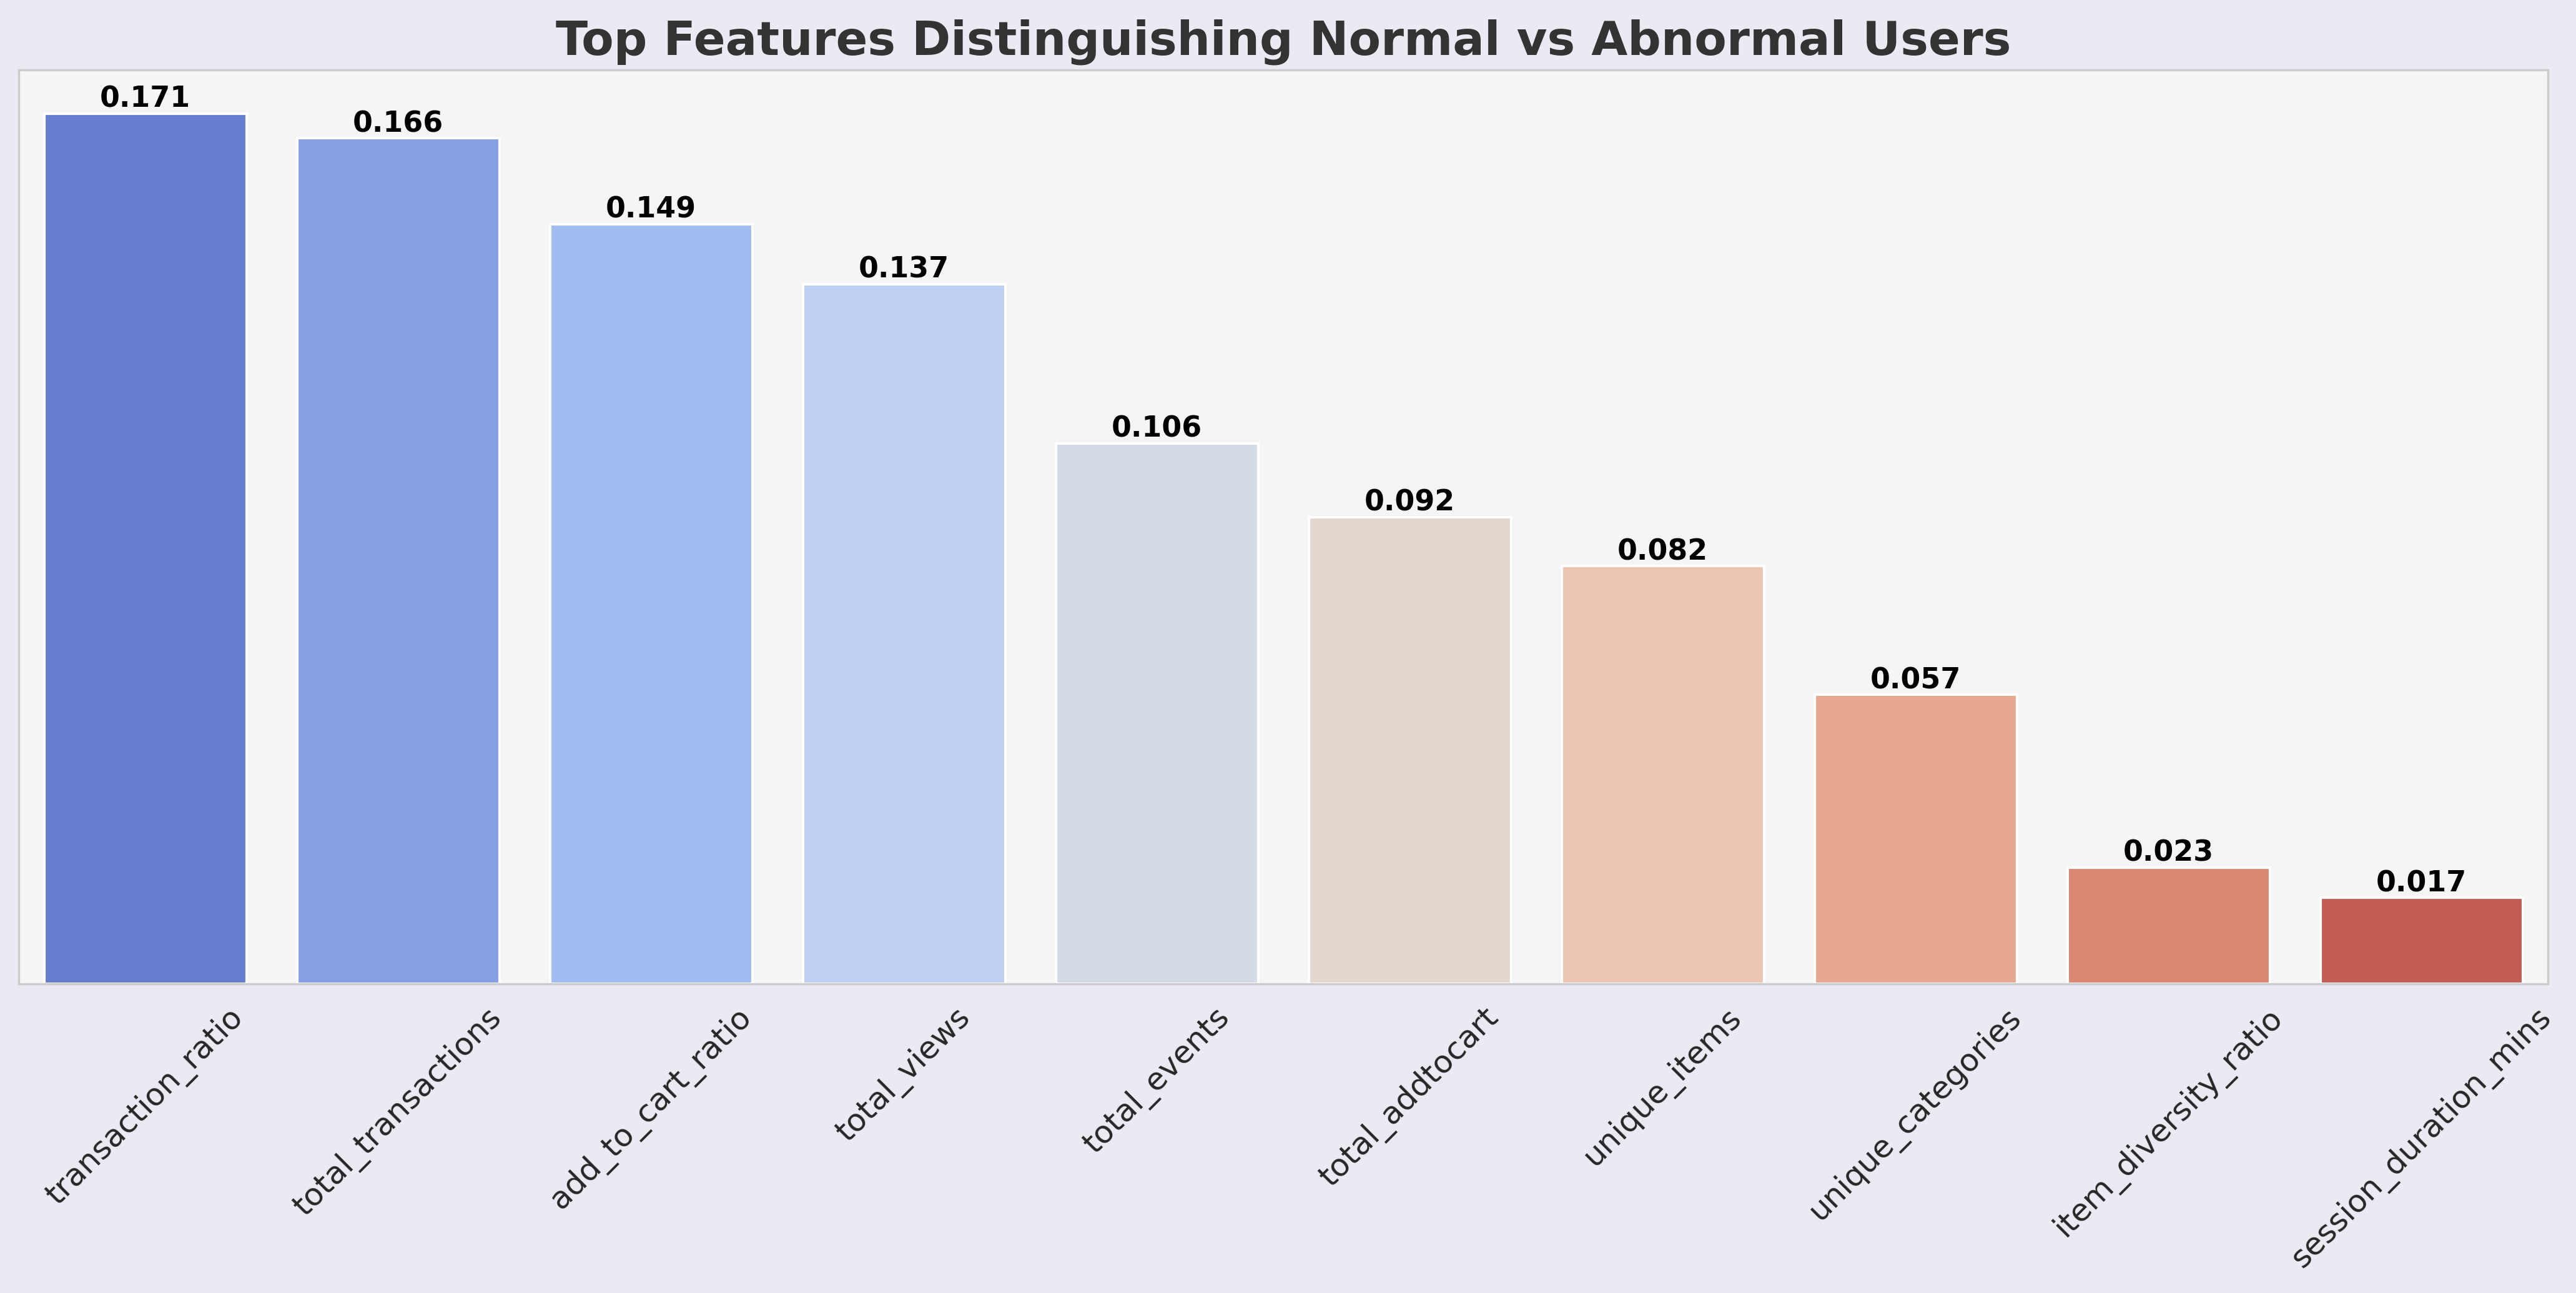

In [ ]:
# Keep top 10 features
top_features = importances.head(10)

# Style & Plot
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7), dpi=300)

bar = sns.barplot(
    data=top_features,
    x='Feature',
    y='Importance',
    palette='coolwarm'
)

# Add labels
for p in bar.patches:
    bar.annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=11, color='black', weight='bold'
    )

# Title & styling
plt.title("Top Features Distinguishing Normal vs Abnormal Users", fontsize=18, weight='bold', color='#333')
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45, fontsize=12)
plt.yticks([])
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().set_facecolor('#eaeaf2')
plt.grid(False)

# Save & Show
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/top_features_user_behavior.png", dpi=300, bbox_inches='tight')
plt.show()

**Findings**

The analysis reveals that transaction ratio is the strongest differentiator between normal and abnormal users, suggesting that purchase completion patterns are the clearest signal for detecting unusual behavior.

This is followed by add-to-cart ratio and total transactions, indicating that abnormal users tend to have significantly different carting and buying habits compared to normal users.

Engagement metrics like total views and total add-to-cart also contribute meaningfully, but less so than conversion-related ratios.

Interestingly, session duration and item diversity ratio have minimal importance, implying that browsing length and product variety are weak indicators of abnormality.

### **8. Can user viewing patterns be used to accurately predict the category of the item they are likely to add to cart?**

**Random Forest**

In [11]:
# Feature extraction
# Separate views and add-to-carts
views_df = df_cleaned_predict[df_cleaned_predict['event'] == 'view'].copy()
cart_df  = df_cleaned_predict[df_cleaned_predict['event'] == 'addtocart'].copy()

# Merge so each add-to-cart sees all prior views by same visitor
merged = cart_df.merge(
    views_df,
    on='visitorid',
    suffixes=('_cart', '_view')
)

# keep only views that happened before the cart time
merged = merged[merged['timestamp_view'] < merged['timestamp_cart']]

# sort so "last_view_cat" truly picks the latest pre-cart view
merged = merged.sort_values(['visitorid', 'itemid_cart', 'timestamp_cart', 'timestamp_view'])

# Aggregate features per (visitor, item added, cart time)
agg_df = merged.groupby(['visitorid', 'itemid_cart', 'timestamp_cart']).agg(
    last_view_cat=('categoryid_view', lambda x: x.iloc[-1]),
    most_freq_cat=('categoryid_view', lambda x: x.mode()[0] if not x.mode().empty else 'OtherID'),
    unique_cats_viewed=('categoryid_view', 'nunique'),
    total_views_before_cart=('categoryid_view', 'size'),
    target_category=('categoryid_cart', 'first')
).reset_index()

# Drop group keys; keep only features
df_category_predict = agg_df.drop(columns=['visitorid', 'itemid_cart', 'timestamp_cart'])

# Replace any missing strings (just in case) and merge rare classes into "OtherID"
for col in ['last_view_cat', 'most_freq_cat', 'target_category']:
    df_category_predict[col] = df_category_predict[col].astype('object').fillna('OtherID')

# Merge ALL classes with < 2 samples into "OtherID" for the TARGET (prevents stratify error)
min_samples = 2
y_counts = df_category_predict['target_category'].value_counts()
rare_targets = y_counts[y_counts < min_samples].index
if len(rare_targets) > 0:
    df_category_predict['target_category'] = df_category_predict['target_category'].replace(rare_targets, 'OtherID')

# (Optional but tidy) also merge rare feature categories so encoders stay compact
for col in ['last_view_cat', 'most_freq_cat']:
    counts = df_category_predict[col].value_counts()
    rare_vals = counts[counts < min_samples].index
    if len(rare_vals) > 0:
        df_category_predict[col] = df_category_predict[col].replace(rare_vals, 'OtherID')

# Sanity check: no class should have count < 2 now
min_class_count = df_category_predict['target_category'].value_counts().min()
print("Min target class count after merging:", int(min_class_count))

# Label-encode categorical columns
cat_features = ['last_view_cat', 'most_freq_cat', 'target_category']
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df_category_predict[col] = le.fit_transform(df_category_predict[col].astype(str))
    label_encoders[col] = le

joblib.dump(label_encoders, "/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Recommendation_App/label_encoders.pkl")

# Train/Test split WITH stratify (now safe)
X = df_category_predict.drop(columns=['target_category'])
y = df_category_predict['target_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

feature_cols = X_train.columns.tolist()

print("Feature dataframe shape:", df_category_predict.shape)
print("Train size:", X_train.shape, " Test size:", X_test.shape)
df_category_predict.head()

Min target class count after merging: 2
Feature dataframe shape: (61474, 5)
Train size: (49179, 4)  Test size: (12295, 4)


,last_view_cat,most_freq_cat,unique_cats_viewed,total_views_before_cart,target_category
0,593,552,1,2,601
1,371,552,4,7,601
2,371,552,4,7,601
3,371,552,4,7,601
4,371,552,4,7,601


In [39]:
print("=== Random Forest ===")

# Train model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
)
rf_model.fit(X_train, y_train)

# Compress and Save trained Model
#import pickle, gzip
#from google.colab import files
#with gzip.open('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Recommendation_App/rf_model.pkl.gz', 'wb') as f:
 #   pickle.dump(rf_model, f)
#files.download('rf_model.pkl.gz')

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Metrics
acc = round(accuracy_score(y_test, y_pred_rf), 4)
top3_acc = round(
    top_k_accuracy_score(y_test, rf_model.predict_proba(X_test), k=3, labels=rf_model.classes_), 4
)

precision_macro = round(precision_score(y_test, y_pred_rf, average='macro'), 4)
recall_macro = round(recall_score(y_test, y_pred_rf, average='macro'), 4)
f1_macro = round(f1_score(y_test, y_pred_rf, average='macro'), 4)

# Summary printout
print(f"Top-1 Accuracy: {acc}")
print(f"Top-3 Accuracy: {top3_acc}")
print(f"Macro Precision: {precision_macro}")
print(f"Macro Recall: {recall_macro}")
print(f"Macro F1-score: {f1_macro}")
# print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
Top-1 Accuracy: 0.8532
Top-3 Accuracy: 0.9217
Macro Precision: 0.5051
Macro Recall: 0.4348
Macro F1-score: 0.4493


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
import sys
import pickle

print(f"Number of trees: {len(rf_model.estimators_)}")
print(f"Max depth: {max(tree.tree_.max_depth for tree in rf_model.estimators_)}")
print(f"Number of features: {rf_model.n_features_in_}")
print("Pickle size (MB):", round(sys.getsizeof(pickle.dumps(rf_model)) / (1024*1024), 2))

Number of trees: 200
Max depth: 50
Number of features: 4
Pickle size (MB): 8538.98


In [35]:
print("=== Optimized Random Forest Training ===")

# Train a smaller Random Forest
rf_model_small = RandomForestClassifier(
    n_estimators=100,
    max_depth=22,
    n_jobs=-1,
    random_state=42
)
rf_model_small.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model_small.predict(X_test)

# Metrics
acc = round(accuracy_score(y_test, y_pred_rf), 4)
top3_acc = round(
    top_k_accuracy_score(y_test, rf_model_small.predict_proba(X_test), k=3, labels=rf_model_small.classes_), 4
)
precision_macro = round(precision_score(y_test, y_pred_rf, average='macro'), 4)
recall_macro = round(recall_score(y_test, y_pred_rf, average='macro'), 4)
f1_macro = round(f1_score(y_test, y_pred_rf, average='macro'), 4)

# Summary printout
print(f"Top-1 Accuracy: {acc}")
print(f"Top-3 Accuracy: {top3_acc}")
print(f"Macro Precision: {precision_macro}")
print(f"Macro Recall: {recall_macro}")
print(f"Macro F1-score: {f1_macro}")

# Save compressed model with joblib
save_path = "/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Recommendation_App/rf_model_small.joblib"
joblib.dump(rf_model_small, save_path, compress=3)  # Compress=3 is a good trade-off

# Check file size
file_size = os.path.getsize(save_path) / (1024 * 1024)
print(f"Compressed Model Size: {file_size:.2f} MB")

# OPTIONAL: Download to local machine
from google.colab import files
files.download(save_path)

=== Optimized Random Forest Training ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Top-1 Accuracy: 0.8526
Top-3 Accuracy: 0.9212
Macro Precision: 0.5131
Macro Recall: 0.4174
Macro F1-score: 0.4434
Compressed Model Size: 43.34 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
import sys
import pickle

print(f"Number of trees: {len(rf_model_small.estimators_)}")
print(f"Max depth: {max(tree.tree_.max_depth for tree in rf_model_small.estimators_)}")
print(f"Number of features: {rf_model_small.n_features_in_}")
print("Pickle size (MB):", round(sys.getsizeof(pickle.dumps(rf_model_small)) / (1024*1024), 2))

Number of trees: 100
Max depth: 22
Number of features: 4
Pickle size (MB): 3156.02


## **RECOMMENDATION SYSTEM**

In [ ]:
import gradio as gr
import pandas as pd
import joblib

# ===== LOAD TRAINED MODEL AND ENCODERS =====
rf_model = joblib.load("rf_model_small.joblib")  # Your trained Random Forest
label_encoders = joblib.load("label_encoders.pkl")  # Dict with encoders for 'last_view_cat', 'most_freq_cat', 'target_category'

# Features used during training (must match exactly)
feature_cols = [
    "last_view_cat",
    "most_freq_cat",
    "unique_cats_viewed",
    "total_views_before_cart"
]

# ===== PREDICTION FUNCTION =====
def recommend_category(last_view_cat, most_freq_cat, unique_cats_viewed, total_views_before_cart):
    """
    Predict the category of item the user is most likely to add to cart
    """

    # Convert inputs to string (to match training format)
    last_view_cat = str(last_view_cat)
    most_freq_cat = str(most_freq_cat)

    # Handle unseen categories by mapping them to "OtherID"
    if last_view_cat not in label_encoders["last_view_cat"].classes_:
        last_view_cat = "Unknown_CatID"
    if most_freq_cat not in label_encoders["most_freq_cat"].classes_:
        most_freq_cat = "Unknown_CatID"

    # Encode categorical features
    last_view_encoded = label_encoders["last_view_cat"].transform([last_view_cat])[0]
    most_freq_encoded = label_encoders["most_freq_cat"].transform([most_freq_cat])[0]

    # Create DataFrame for prediction
    input_df = pd.DataFrame([[last_view_encoded, most_freq_encoded, unique_cats_viewed, total_views_before_cart]],
                            columns=feature_cols)

    # Predict top-1
    pred_encoded = rf_model.predict(input_df)[0]
    pred_category = label_encoders["target_category"].inverse_transform([pred_encoded])[0]

    # Predict top-3
    probs = rf_model.predict_proba(input_df)[0]
    top3_indices = probs.argsort()[::-1][:3]
    top3_results = [
        (label_encoders["target_category"].inverse_transform([idx])[0], f"{probs[idx]*100:.2f}%")
        for idx in top3_indices
    ]

    return pred_category, top3_results

# ===== GRADIO INTERFACE =====
with gr.Blocks() as demo:
    gr.Markdown("## 🛒 Product Category Recommendation System")
    gr.Markdown("Predict the most likely category a user will add to cart, based on their viewing behavior.")

    with gr.Row():
        last_view_cat = gr.Textbox(label="Last Viewed Category ID", placeholder="Enter category ID of last viewed item")
        most_freq_cat = gr.Textbox(label="Most Frequently Viewed Category ID", placeholder="Enter most frequent category ID viewed")

    with gr.Row():
        unique_cats_viewed = gr.Number(label="Number of Unique Categories Viewed", value=3)
        total_views_before_cart = gr.Number(label="Total Views Before Add-to-Cart", value=5)

    predict_btn = gr.Button("Predict Category")

    with gr.Row():
        output_category = gr.Textbox(label="Predicted Category", interactive=False)
        output_top3 = gr.JSON(label="Top 3 Predictions (Category, Probability)")

    predict_btn.click(
        fn=recommend_category,
        inputs=[last_view_cat, most_freq_cat, unique_cats_viewed, total_views_before_cart],
        outputs=[output_category, output_top3]
    )

if __name__ == "__main__":
    demo.launch()


**How it all works**

1. You enter session behavior (last viewed, most frequent, diversity, total views).

2. The model encodes these features and runs them through the trained Random Forest model.

3. The output gives the predicted category + top 3 alternatives with probabilities.